# **Import packages and Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install until

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import until
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from tqdm.notebook import tqdm
import time
from datetime import datetime

#from My_code.Metrics import *

from yellowbrick.target import FeatureCorrelation

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from itertools import permutations

style.use('seaborn-whitegrid')

In [ ]:
import os
path = os.getcwd()
path

'/content'

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/odor/2022_odor.zip (Unzipped Files)/Linux/[2021, 2022] 악취 - 양돈 농가/[2022 년]"

In [ ]:
data = pd.read_csv(path+"/DAT/preprocessed data.csv")
print(data.shape)
data.head(3)

(212, 22)


complex odor    Ammoina  Hydorgen sulfide  Methyl mercaptan  \
0   1314.204414  10.374437        149.737225         15.883465   
1    398.443371   1.605300        127.205918          4.587934   
2    350.245307   1.618517        118.306453          4.675428   

   Dimethyl sulfide  Dimethyl disulfide  Acetic acid  Propionic acid  \
0               0.0            0.166644  1272.659247      354.403061   
1               0.0            0.116850    34.234155       15.955100   
2               0.0            0.117278    22.928672        7.228658   

   iso-Butryic aicd  Butricy aicd  ...     Phenol  p-Cresol    Indole  \
0          0.155839     10.136117  ...  75.619672  0.050000  0.050000   
1          2.024014     20.602569  ...   4.145208  1.142263  0.848513   
2          0.951650      5.772918  ...   3.251023  0.980568  0.495689   

    Skatole  boundary  in  out  fall  spring  summer  
0  5.045635         1   0    0     0       1       0  
1  4.960978         1   0    0     0       1       0  
2  4.801511         1   0    0     0       1       0  

[3 rows x 22 columns]

# **날씨 변수 추가**

In [ ]:
total = pd.read_csv(path + "/DAT/total data.csv")
outlier = total[total["complex odor"] > 9000]
total_ = total.drop(index = outlier.index).reset_index(drop = True) 

In [ ]:
time_info = total_["time"]
for i in range(data.shape[0]) :
    time_info.values[i] = datetime.strptime(time_info[i], "%y.%m.%d").strftime("%Y-%m-%d")
# time_info

In [ ]:
weather = pd.read_csv(path + "/DAT/weather.csv", encoding = "euc-kr")
# print(weather.columns)
wea = weather.iloc[:, [0,1,4,5,6]]
wea.columns = ["time", "temp", "humidity_0.5", "humidity_1.5", "humidity_4.0"]
wea.head(3)

time  temp  humidity_0.5  humidity_1.5  humidity_4.0
0  2018-04-01  16.0          73.0          74.0          75.0
1  2018-04-02  18.6          73.0          74.0          74.0
2  2018-04-03  19.3          71.0          72.0          73.0

In [ ]:
data["time"] = time_info
data = pd.merge(left = data, right = wea, on = "time", how = "left")
data.drop(columns = ["time"], inplace = True)
data.head(3)

complex odor    Ammoina  Hydorgen sulfide  Methyl mercaptan  \
0   1314.204414  10.374437        149.737225         15.883465   
1    398.443371   1.605300        127.205918          4.587934   
2    350.245307   1.618517        118.306453          4.675428   

   Dimethyl sulfide  Dimethyl disulfide  Acetic acid  Propionic acid  \
0               0.0            0.166644  1272.659247      354.403061   
1               0.0            0.116850    34.234155       15.955100   
2               0.0            0.117278    22.928672        7.228658   

   iso-Butryic aicd  Butricy aicd  ...  boundary  in  out  fall  spring  \
0          0.155839     10.136117  ...         1   0    0     0       1   
1          2.024014     20.602569  ...         1   0    0     0       1   
2          0.951650      5.772918  ...         1   0    0     0       1   

   summer  temp  humidity_0.5  humidity_1.5  humidity_4.0  
0       0  12.2          79.0          79.0          80.0  
1       0  17.1          68.0          68.0          69.0  
2       0  24.0          70.0          72.0          72.0  

[3 rows x 26 columns]

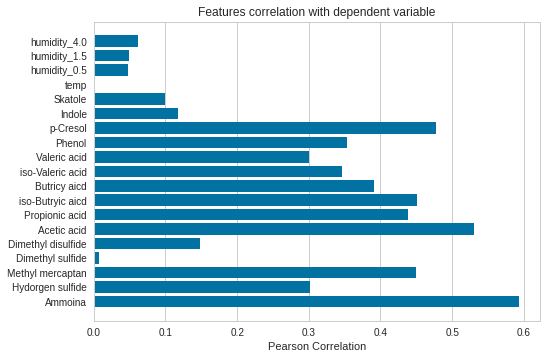

In [ ]:
### Feature correlation
feature_names = data.columns.drop(["complex odor", "boundary", "in", "out", "fall", "spring", "summer"])
X, y = data[feature_names], data["complex odor"]

# Create a list of the feature names
features = np.array(feature_names)

# Instantiate the visualizer
visualizer = FeatureCorrelation(labels = features)
visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.show();

# **Modeling**

## **_Data split**

In [ ]:
data2 = data.drop(columns = ["temp", "humidity_0.5", "humidity_1.5", "humidity_4.0"])

In [ ]:
# X, y = data.drop(columns = ["complex odor"]), data["complex odor"]
X, y = data2.drop(columns = ["complex odor"]), data["complex odor"]
print(X.shape, y.shape)

(212, 21) (212,)


## **_y classification**

In [ ]:
# condlist = [((y <= 100)), ((y > 100) & (y <= 400)), ((y > 400 ) & (y <= 1500)), ((y > 1500 ) & (y <= 7000))]
# choicelist = [0, 1, 2, 3]
# y_class = np.select(condlist, choicelist, 4).astype("int")
# y_class[:10]
condlist = [((X["boundary"] == 1) & (y <= 15)), ((X["boundary"] == 1) & (y > 15)),
            ((X["boundary"] == 0) & (y <= 500)), ((X["boundary"] == 0) & (y > 500))]
choicelist = [0, 1, 0, 1]
y_class = np.select(condlist, choicelist, 3).astype("int")
y_class[:10]

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1])

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y_class, test_size = 0.2, shuffle = True, random_state = 999)
print(train_X.shape, test_X.shape, train_y.shape, test_y.shape)

(169, 21) (43, 21) (169,) (43,)


## **_Standard scaler**

In [ ]:
catego = ["boundary", "in", "out", "fall", "spring", "summer"]

catego_train_X = train_X[catego].reset_index(drop = True)
numeric_train_X = train_X.drop(columns = catego).reset_index(drop = True)

catego_test_X = test_X[catego].reset_index(drop = True)
numeric_test_X = test_X.drop(columns = catego).reset_index(drop = True)

In [ ]:
std = StandardScaler().fit(numeric_train_X)

train_std = pd.DataFrame(std.transform(numeric_train_X), columns = numeric_train_X.columns)
new_train_X = pd.concat([train_std, catego_train_X], axis = 1)
test_std = pd.DataFrame(std.transform(numeric_test_X), columns = numeric_test_X.columns)
new_test_X = pd.concat([test_std, catego_test_X], axis = 1)

In [ ]:
new_train_X.head(3)

Ammoina  Hydorgen sulfide  Methyl mercaptan  Dimethyl sulfide  \
0 -0.486784         -0.525505         -0.386299         -0.149633   
1 -0.625988         -0.527447         -0.386299         -0.149633   
2 -0.162868          0.576290          0.261856         -0.149633   

   Dimethyl disulfide  Acetic acid  Propionic acid  iso-Butryic aicd  \
0            -0.20346    -0.545246       -0.589395          -0.57746   
1            -0.20346    -0.559175       -0.592444          -0.57746   
2            -0.20346    -0.265021       -0.240824          -0.57746   

   Butricy aicd  iso-Valeric acid  ...    Phenol  p-Cresol    Indole  \
0     -0.586400         -0.523653  ... -0.473083 -0.539755 -0.251045   
1     -0.582324         -0.523653  ... -0.463737 -0.539755 -0.251045   
2     -0.385808         -0.465419  ... -0.265924 -0.415799 -0.251045   

    Skatole  boundary  in  out  fall  spring  summer  
0 -0.290445         0   0    1     0       0       1  
1 -0.290445         1   0    0     0       0       1  
2 -0.290445         0   0    1     0       0       1  

[3 rows x 21 columns]

## **_Basic modeling**

In [ ]:
rf_model = RandomForestClassifier(random_state = 999).fit(new_train_X, train_y)
rf_pred = rf_model.predict(new_test_X)

xg_model = XGBClassifier(random_state = 999, eval_metric = "mlogloss", use_label_encoder=False).fit(new_train_X, train_y)
xg_pred = xg_model.predict(new_test_X)

et_model = ExtraTreesClassifier(random_state = 999).fit(new_train_X, train_y)
et_pred = et_model.predict(new_test_X)

knn_model = KNeighborsClassifier().fit(new_train_X, train_y)
knn_pred = knn_model.predict(new_test_X)

svc_model = SVC().fit(new_train_X, train_y)
svc_pred = svc_model.predict(new_test_X)

lgb_model = LGBMClassifier().fit(new_train_X, train_y)
lgb_pred = lgb_model.predict(new_test_X)

print("\033[31m" + "================ F1 score ===============" + "\033[0m")
print("RF f1 score : ", np.round(f1_score(test_y, rf_pred, average = "micro"), 4))
print("XG f1 score : ", np.round(f1_score(test_y, xg_pred, average = "micro"), 4))
print("ET f1 score : ", np.round(f1_score(test_y, et_pred, average = "micro"), 4))
print("KNN f1 score : ", np.round(f1_score(test_y, knn_pred, average = "micro"), 4))
print("SVC f1 score : ", np.round(f1_score(test_y, svc_pred, average = "micro"), 4))
print("LGB f1 score : ", np.round(f1_score(test_y, lgb_pred, average = "micro"), 4))

print("\033[31m" + "================== ACC ==================" + "\033[0m")
print("RF Acc : ", np.round(accuracy_score(test_y, rf_pred), 4))
print("XG Acc : ", np.round(accuracy_score(test_y, xg_pred), 4))
print("ET Acc : ", np.round(accuracy_score(test_y, et_pred), 4))
print("KNN Acc : ", np.round(accuracy_score(test_y, knn_pred), 4))
print("SVC Acc : ", np.round(accuracy_score(test_y, svc_pred), 4))
print("LGB Acc : ", np.round(accuracy_score(test_y, lgb_pred), 4))

================ F1 score ===============
RF f1 score :  0.6977
XG f1 score :  0.7674
ET f1 score :  0.6977
KNN f1 score :  0.6047
SVC f1 score :  0.5814
LGB f1 score :  0.6977
================== ACC ==================
RF Acc :  0.6977
XG Acc :  0.7674
ET Acc :  0.6977
KNN Acc :  0.6047
SVC Acc :  0.5814
LGB Acc :  0.6977


## **_Gridsearch modeling**

In [ ]:
def grid_classification(name, model, train_X, train_y, test_X,
                        n_split = 5, score = "f1_micro", SEED = 999) :
    
    if 'LM' in name:
        parameters = {f'{name}__C': [0.001, 0.01, 0.1, 1, 10, 100], f'{name}__penalty': ['l2'], f'{name}__max_iter':[100,1000]}
    elif 'KNN' in name:
        parameters = {f'{name}__n_neighbors': list(range(1, 15, 1)), f'{name}__weights': ['uniform','distance'], f'{name}__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
    elif 'SVC' in name:
        parameters = {f'{name}__C': [0.05, 0.5,1.0],f'{name}__gamma': ['auto'] ,f'{name}__kernel': ['linear', 'rbf']}
    elif 'Random Forest' in name:
        parameters = {f'{name}__n_estimators' : list(range(10,100,5)), f'{name}__max_depth' : list(range(1,15,1)), f'{name}__min_samples_leaf' : list(range(1,10,1)),
                      f'{name}__min_samples_split':[2,5,8,10, 12], f'{name}__criterion' : ["gini", "entropy"]}
    elif 'Extra Trees' in name:
        parameters = { f'{name}__max_depth': [1,5,7], f'{name}__n_estimators': [1,3,5]}
    elif 'Lightgbm' in name:
        parameters = { f'{name}__num_leaves': [31, 127], f'{name}__max_depth':[3,4,5],f'{name}__min_child_weight':[1e-7, 1e-3, 1e-1, 1e1, 1e3, 1e5],f'{name}__min_data_in_leaf': [30, 50, 100]} 
    elif 'XGboost' in name:
        parameters = {f'{name}__min_child_weight': [3,5,10], f'{name}__max_depth':[3,4,5]}

    start = time.time()
    CV = KFold(n_splits = n_split, random_state = SEED, shuffle=True)
    gscv = GridSearchCV(model, param_grid = parameters, cv = CV, scoring = score, n_jobs = -1)
    gscv.fit(train_X, np.ravel(train_y))
    end = time.time()
    
    best_model = gscv.best_estimator_
    pred = best_model.predict(test_X)
        
        
    print("\033[31m" + "============== Model : {} ==============".format(name) + "\033[0m")
    print("소요 시간 : ", f"{end - start:.5f} sec")
    print("Final parameters : ", gscv.best_params_)
    print("Best score : ", np.round(gscv.best_score_, 4))
        
    return {"pred" : pred, "best model" : best_model}

In [ ]:
def GetBasedModel(SEED = 999): # 모델 선언
    model_dict = {'KNN' : KNeighborsClassifier(), 'SVC' : SVC(), 'Random Forest' : RandomForestClassifier(random_state = SEED),
                  'Extra Trees' : ExtraTreesClassifier(random_state = SEED), 'Lightgbm' : LGBMClassifier(random_state = SEED), 
                  'XGboost' : XGBClassifier(random_state = SEED, eval_metric = "mlogloss", use_label_encoder=False)}
    pipelines = []
    for model_name, model in model_dict.items(): 
        pipelines.append((model_name , Pipeline([(model_name, model)])))
    return pipelines    

In [ ]:
preds = {}
best_models = {}
Models = GetBasedModel()

for name, model in tqdm(Models):
    grid_reuslt = grid_classification(name, model, new_train_X, train_y, new_test_X, score = "f1_micro")
    
    pred = grid_reuslt["pred"]
    preds[name] = pred
    
    best_model = grid_reuslt["best model"]
    best_models[name] = best_model

  0%|          | 0/6 [00:00<?, ?it/s]

============== Model : KNN ==============
소요 시간 :  4.27608 sec
Final parameters :  {'KNN__algorithm': 'auto', 'KNN__n_neighbors': 5, 'KNN__weights': 'distance'}
Best score :  0.6806
============== Model : SVC ==============
소요 시간 :  0.22666 sec
Final parameters :  {'SVC__C': 0.5, 'SVC__gamma': 'auto', 'SVC__kernel': 'linear'}
Best score :  0.6217
============== Model : Random Forest ==============
소요 시간 :  7738.51994 sec
Final parameters :  {'Random Forest__criterion': 'gini', 'Random Forest__max_depth': 9, 'Random Forest__min_samples_leaf': 2, 'Random Forest__min_samples_split': 2, 'Random Forest__n_estimators': 55}
Best score :  0.7162
============== Model : Extra Trees ==============
소요 시간 :  0.40170 sec
Final parameters :  {'Extra Trees__max_depth': 5, 'Extra Trees__n_estimators': 5}
Best score :  0.6809
============== Model : Lightgbm ==============
소요 시간 :  10.17818 sec
Final parameters :  {'Lightgbm__max_depth': 3, 'Lightgbm__min_child_weight': 1e-07, 'Lightgbm__min_data_in_leaf

In [ ]:
  0%|          | 0/6 [00:00<?, ?it/s]
============== Model : KNN ==============
소요 시간 :  1.62916 sec
Final parameters :  {'KNN__algorithm': 'auto', 'KNN__n_neighbors': 4, 'KNN__weights': 'distance'}
Best score :  0.692
============== Model : SVC ==============
소요 시간 :  0.10404 sec
Final parameters :  {'SVC__C': 0.5, 'SVC__gamma': 'auto', 'SVC__kernel': 'linear'}
Best score :  0.6504
============== Model : Random Forest ==============
소요 시간 :  907.81441 sec
Final parameters :  {'Random Forest__criterion': 'entropy', 'Random Forest__max_depth': 10, 'Random Forest__min_samples_leaf': 2, 'Random Forest__min_samples_split': 2, 'Random Forest__n_estimators': 10}
Best score :  0.7219
============== Model : Extra Trees ==============
소요 시간 :  0.17258 sec
Final parameters :  {'Extra Trees__max_depth': 5, 'Extra Trees__n_estimators': 3}
Best score :  0.6749
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
============== Model : Lightgbm ==============
소요 시간 :  2.11746 sec
Final parameters :  {'Lightgbm__max_depth': 3, 'Lightgbm__min_child_weight': 1e-07, 'Lightgbm__min_data_in_leaf': 30, 'Lightgbm__num_leaves': 31}
Best score :  0.6629
/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
============== Model : XGboost ==============
소요 시간 :  8.05950 sec
Final parameters :  {'XGboost__gpu_id': 0, 'XGboost__max_depth': 3, 'XGboost__min_child_weight': 3, 'XGboost__tree_method': 'gpu_hist'}
Best score :  0.6923

In [ ]:
def results (model_name, preds = preds) :
    
    pred = preds[model_name]
    f1 = f1_score(test_y, pred, average = "micro")
    acc = accuracy_score(test_y, pred)
    
    print("F1-score : ", np.round(f1, 4))
    print("Accuracy : ", np.round(acc, 4))

In [ ]:
model_names = [Models[i][0] for i in range(len(Models))]
for i in range(len(model_names)) :
    print("\033[31m" + "====== {} ======".format(model_names[i]) + "\033[0m")
    results(model_names[i])

In [ ]:
style.use('seaborn-white')
f, axes = plt.subplots(1, 6, figsize=(30, 5), sharey ='row')
for i, name in enumerate(model_names) :
    cf_matrix = confusion_matrix(test_y, preds[name])
    conf = ConfusionMatrixDisplay(cf_matrix, display_labels = [0,1,2,3,4])
    conf.plot(ax = axes[i], cmap = plt.cm.Blues)
    conf.ax_.set_title(name, fontsize = 15)
    conf.im_.colorbar.remove()
    conf.ax_.set_xlabel('')
    if i != 0 :
        conf.ax_.set_ylabel('')
f.text(0.4, 0.1, 'Predicted label', ha = 'left')
f.colorbar(conf.im_, ax = axes);

In [ ]:
sv_model = SVC(C = 0.5, gamma = 'auto', kernel = 'linear')

In [ ]:
sv_model.fit(new_train_X, train_y)
pred_sc = sv_model.predict(new_test_X)

In [ ]:
rf_model = RandomForestClassifier(criterion= 'entropy', max_depth = 10, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 10)

In [ ]:
rf_model.fit(new_train_X, train_y)
rf_pred = rf_model.predict(new_test_X)

In [ ]:
ex_model = ExtraTreesClassifier(max_depth = 5, n_estimators = 3)

In [ ]:
ex_model.fit(new_train_X, train_y)
ex_pred = ex_model.predict(test_X)

In [ ]:
xg_model = XGBClassifier(max_depth=3, min_child_weight=3,random_state=999)

In [ ]:
xg_model.fit(new_train_X, train_y)
xg_pred = xg_model.predict(new_test_X)

In [ ]:
def classification_metrics(y_test, y_pred):
    # ppv = 정밀도
    # npv = 음성 예측도
    
    cnf_matrix = confusion_matrix(y_test,y_pred,labels=[0,1])
    
#     FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix);  FP = FP.astype(float)  
#     FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix);  FN = FN.astype(float)
#     TP = np.diag(cnf_matrix);                           TP = TP.astype(float)
#     TN = cnf_matrix.sum() - (FP + FN + TP);             TN = TN.astype(float)
    
    FP = cnf_matrix[1,0];  FP = FP.astype(float)  
    FN = cnf_matrix[0,1];  FN = FN.astype(float)
    TP = cnf_matrix[0,0];  TP = TP.astype(float)
    TN = cnf_matrix[1,1];  TN = TN.astype(float)
    
    NPV = TN / (TN+FN) # Negative predictive value
    
#     fpr, tpr,  _ = roc_curve(y_test, y_pred, pos_label=1)
    
    Sensitivity = np.round((TP / (TP+FN)),4)
    Specificity = np.round((TN / (FP+TN)),4)
    ppv = np.round(TP/(TP+FP),4)
    npv = np.round(NPV,4)
    Precision = TP / (TP + FP)
    Accuracy = (TP + TN) / (TP + TN + FP +FN)                              # accuracy_score(test_y, pred)
    F1_score =  2 * (Precision * Sensitivity) / (Precision + Sensitivity)  # f1_score(test_y, pred, average = "micro")
        
    print("F1-score : ", np.round(F1_score, 4))
    print("Accuracy : ", np.round(Accuracy, 4))
    print("Precision : ", np.round(Precision, 4))
    print("Sensitivity : ", np.round(Sensitivity, 4))
    print("Specificity : ", np.round(Specificity, 4))
    print("ppv : ", np.round(ppv, 4))
    print("npv : ", np.round(npv, 4))
    
    
#     return ppv, npv, Sensitivity, Specificity, TP, FN, FP, TN

In [ ]:
classification_metrics(test_y, xg_pred)

F1-score :  0.6667
Accuracy :  0.7209
Precision :  0.6
Sensitivity :  0.75
Specificity :  0.7037
ppv :  0.6
npv :  0.8261


In [ ]:
model_names = [Models[i][0] for i in range(len(Models))]
for i in range(len(model_names)) :
    print("\033[31m" + "====== {} ======".format(model_names[i]) + "\033[0m")
#     results(model_names[i])
    classification_metrics(test_y, preds[model_names[i]])

### Partial Dependence Plot


In [ ]:
!pip install pdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pdp: filename=pdp-0.3.0-py3-none-any.whl size=6616 sha256=2c14236bca36804f3bf7f3e5289163a7afb794015a80d1eba7ef6215362196cc
  Stored in directory: /root/.cache/pip/wheels/86/3f/21/790268989f0e594527d3b781d80e150499eb918f8c88c1509a
Successfully built pdp


In [ ]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 34.0 MB 1.4 MB/s 
     |████████████████████████████████| 13.1 MB 21.1 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=803e001fd916be4c63032aa931097c7db31276c47471a3adea84b4f257530d5b
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=efba3fff5c363e91fb2ac9c5efba6cbe0999ba1857c13eff033cce29b5cc32e6
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pdpbox sklearn
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp, info_plots

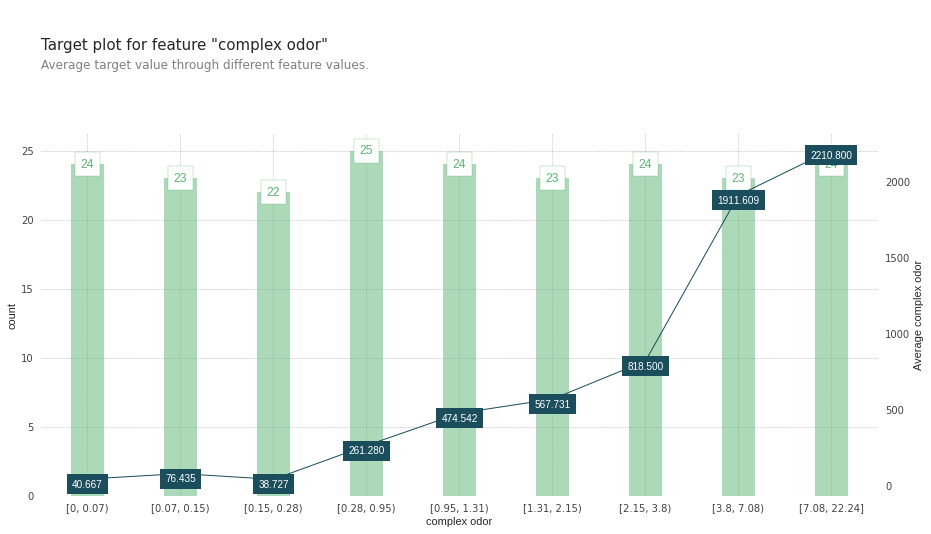

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df = data2,
    feature = 'Ammoina',
    feature_name = 'complex odor',
    target = 'complex odor'
)

In [ ]:
y_df = pd.DataFrame(y_class, columns = ['y'])

In [ ]:
dataset = pd.concat([y_df, X], axis = 1)

In [ ]:
odor_features = dataset.iloc[:,1:].columns
odor_target = dataset.columns[0]

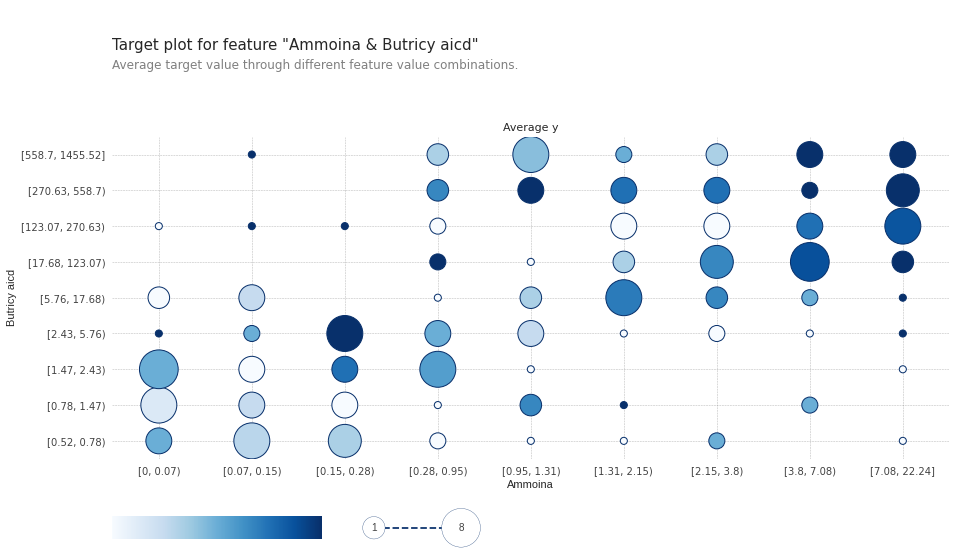

In [ ]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df = dataset,
    features = ['Ammoina', 'Butricy aicd'],
    feature_names = ['Ammoina', 'Butricy aicd'],
    target = odor_target
)

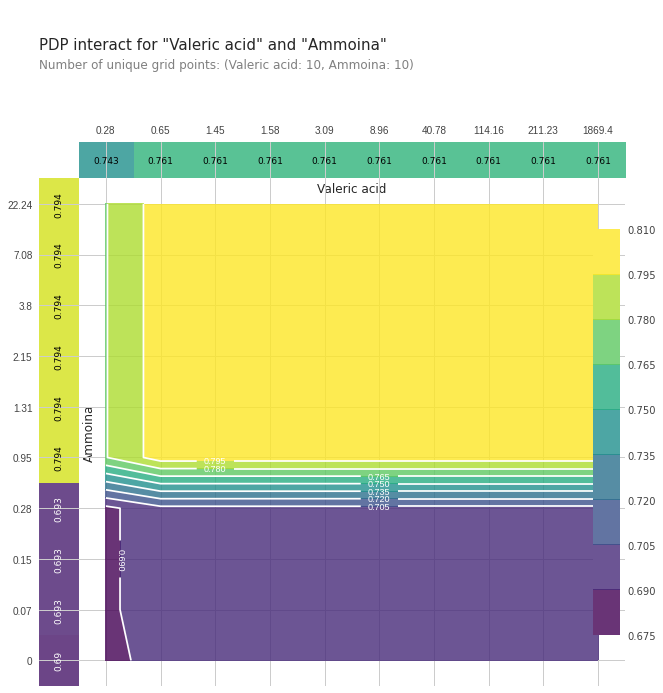

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = rf_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Valeric acid', 'Ammoina']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Valeric acid', 'Ammoina'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

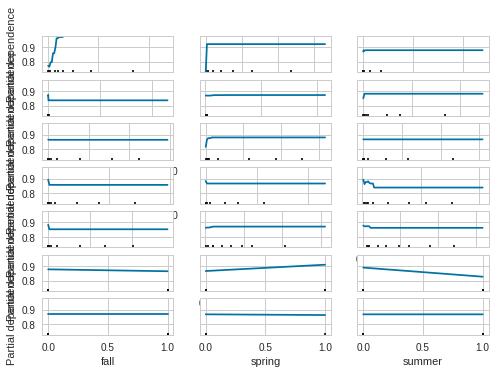

In [ ]:
PartialDependenceDisplay.from_estimator(xg_model, X, odor_features, target = 3)

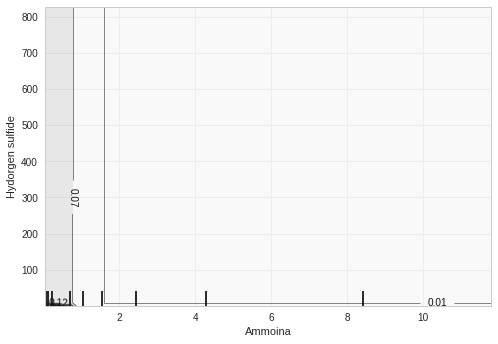

In [ ]:
PartialDependenceDisplay.from_estimator(xg_model, X, [('Ammoina', 'Hydorgen sulfide')], target = 2)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
odor_features

Index(['Ammoina', 'Hydorgen sulfide', 'Methyl mercaptan', 'Dimethyl sulfide',
       'Dimethyl disulfide', 'Acetic acid', 'Propionic acid',
       'iso-Butryic aicd', 'Butricy aicd', 'iso-Valeric acid', 'Valeric acid',
       'Phenol', 'p-Cresol', 'Indole', 'Skatole', 'boundary', 'in', 'out',
       'fall', 'spring', 'summer'],
      dtype='object')

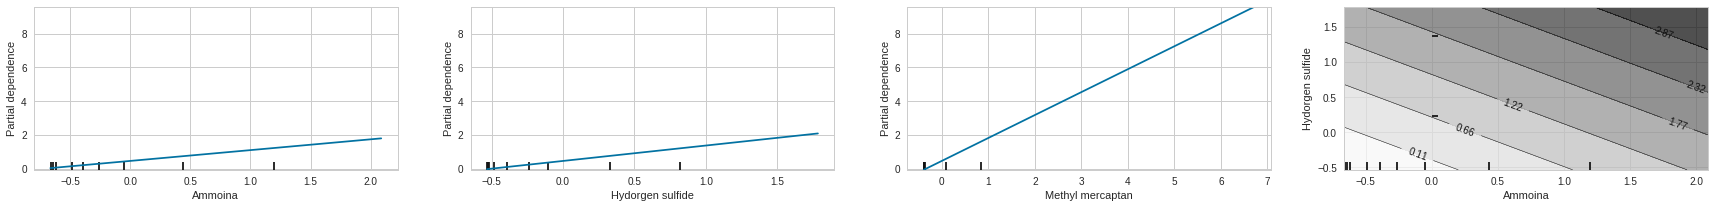

In [ ]:
_, ax = plt.subplots(ncols=4, figsize=(30, 3))
display = PartialDependenceDisplay.from_estimator(  
sv_model, 
    new_train_X,
    features = ['Ammoina','Hydorgen sulfide', 'Methyl mercaptan', ('Ammoina','Hydorgen sulfide')],
#   kind = ['both', 'both', 'average'],
    target = 3,
    ax = ax,
   # **common_params
)

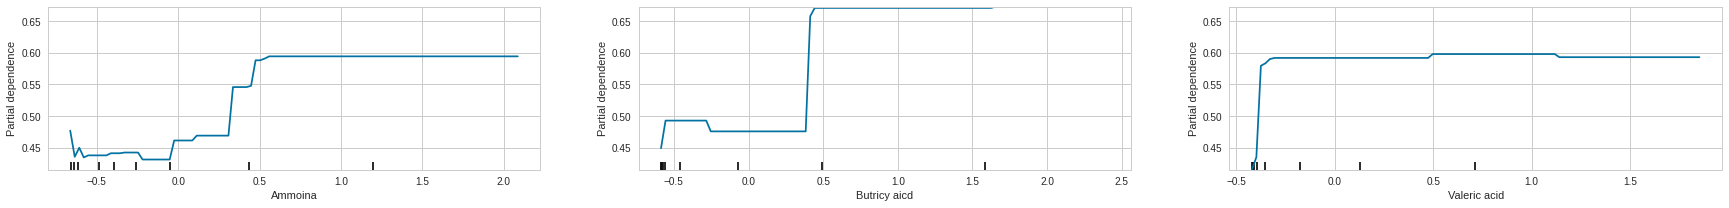

In [ ]:
_, ax = plt.subplots(ncols=3, figsize=(30, 3))
display = PartialDependenceDisplay.from_estimator(
    xg_model,
    new_train_X,
    features = ['Ammoina','Butricy aicd', 'Valeric acid' ],# 'Methyl mercaptan', ('Ammoina','Hydorgen sulfide')],
#    kind = ['both', 'both', 'average'],
    target = 2,
    ax = ax,
   # **common_params
)

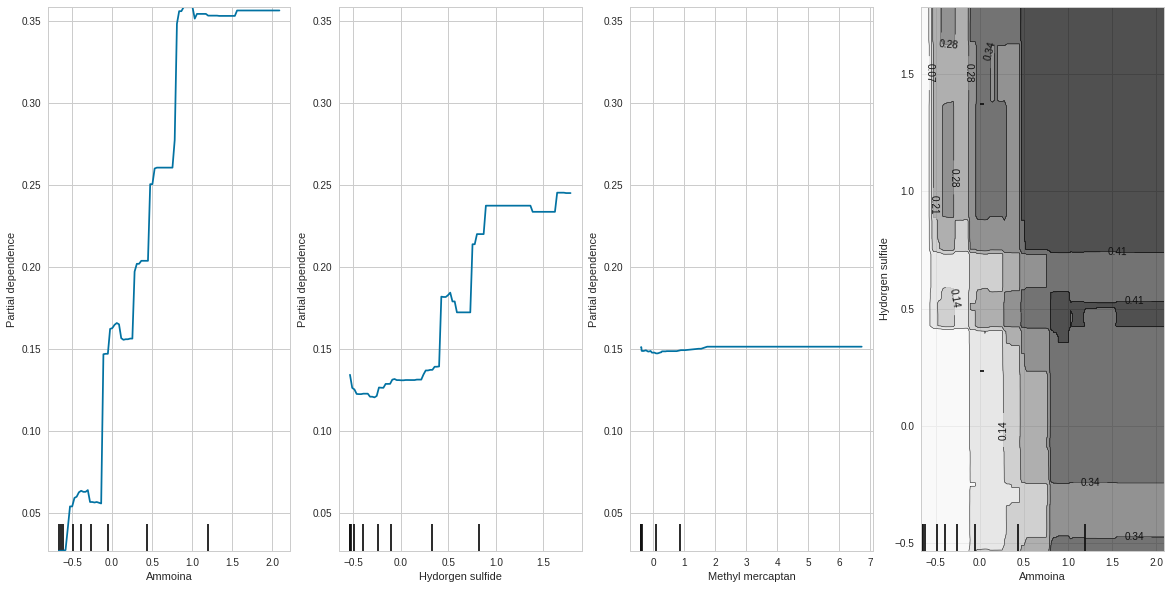

In [ ]:
_, ax = plt.subplots(ncols=4, figsize=(30, 3))
display = PartialDependenceDisplay.from_estimator(
    rg_model,
    new_train_X,
    features = ['Ammoina','Hydorgen sulfide', 'Methyl mercaptan', ('Ammoina','Hydorgen sulfide')],
#    kind = ['both', 'both', 'average'],
    target = 3,
    ax = ax,
   # **common_params
)

In [ ]:
def isolate_option(feature_, model, tp = True):
  for i in tqdm(range(len(feature_))):
    pdp_bp = pdp.pdp_isolate(
        model = model,
        dataset = dataset,
        model_features = feature_,
        feature = feature_[i]
        )
    fig, axes = pdp.pdp_plot(pdp_bp,
                             feature_[i],
                             plot_lines = tp,
                             frac_to_plot=1,
                             plot_pts_dist = True)
  
  return pdp_bp

In [ ]:
paper_odor = ['Ammoina', 'Butricy aicd', 'Propionic acid','Valeric acid','Hydorgen sulfide',  'Skatole']
real_odor = ['Ammonia (NH3)', 'butyric acid (BTA)', 'Propanoic acid (PPA)', 'valeric acid (VLA)', 'Hydrogen sulfide (H2S)', 'Skatole (SK)']

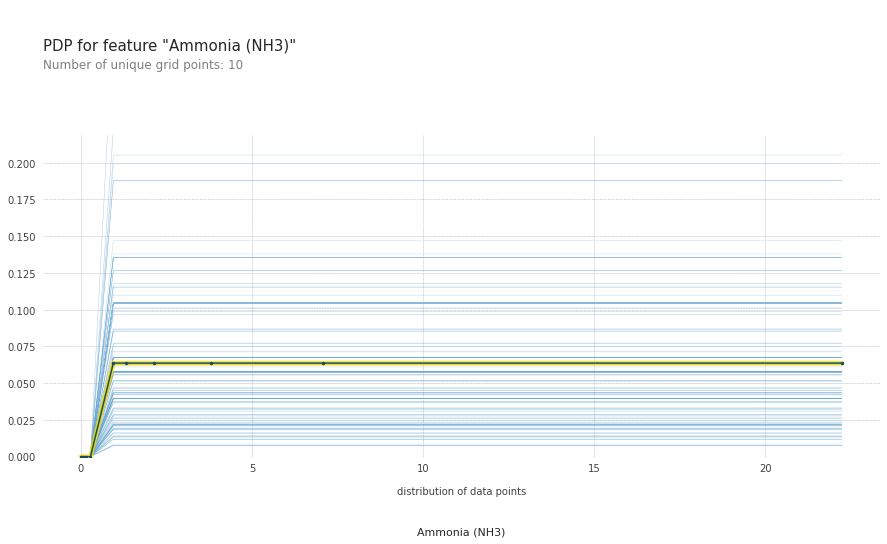

In [ ]:
pdp_bp = pdp.pdp_isolate(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    feature = 'Ammoina'
    )
fig, axes = pdp.pdp_plot(pdp_bp,
                         'Ammonia (NH3)',
                         plot_lines = True,
                         frac_to_plot=1,
                         plot_pts_dist = True)

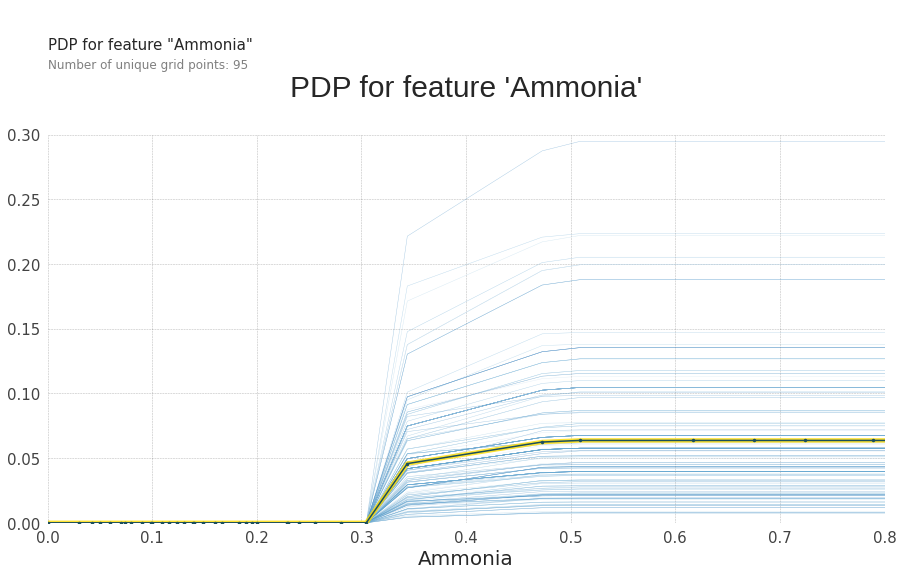

In [ ]:
pdp_plot(pdp_bp, 'Ammonia', plot_lines = True)
plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

plt.rc('font', size = 100)
plt.rc('axes', labelsize=20)
plt.xlim((0, 0.8))
plt.ylim(0, 0.3)
plt.xlabel("Ammonia", fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("PDP for feature 'Ammonia'\n", fontsize = 30);

#plt.savefig("PDP isolate plot(svm_NH3).png")

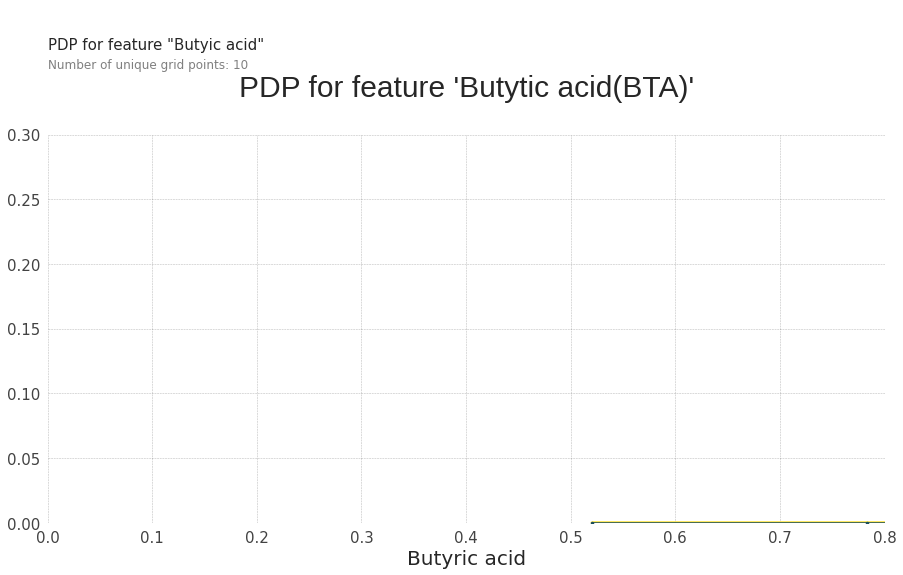

In [ ]:
pdp_plot(pdp_bp, 'Butyic acid', plot_lines = True)
plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

plt.rc('font', size = 100)
plt.rc('axes', labelsize=20)
plt.xlim((0, 0.8))
plt.ylim(0, 0.3)
plt.xlabel("Butyric acid", fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("PDP for feature 'Butytic acid(BTA)'\n", fontsize = 30);

(0.0, 1.0)

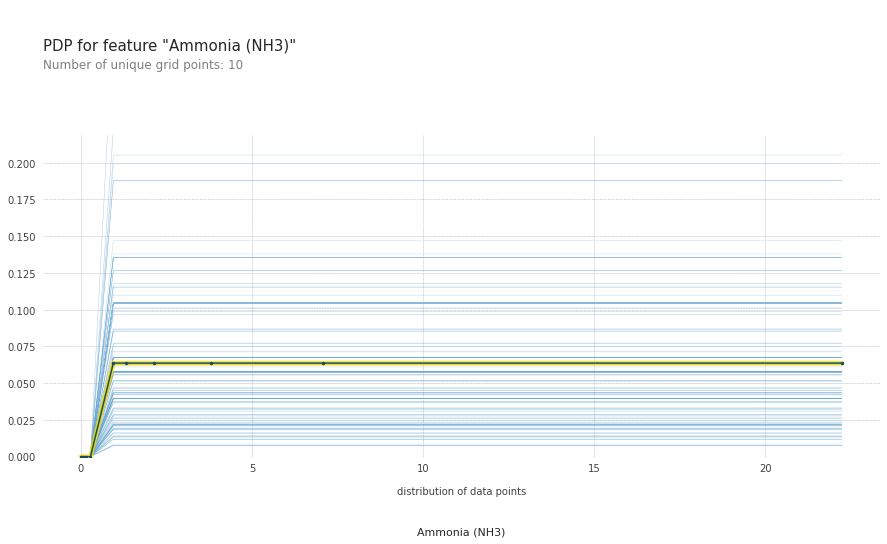

In [ ]:
pdp_bp = pdp.pdp_isolate(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    feature = 'Ammoina'
    )
fig, axes = pdp.pdp_plot(pdp_bp,
                         'Ammonia (NH3)',
                         plot_lines = True,
                         frac_to_plot=1,
                         plot_pts_dist = True)
plt.xlim(0, 1)
#plt.savefig("PDP isolate plot(NH3).png")

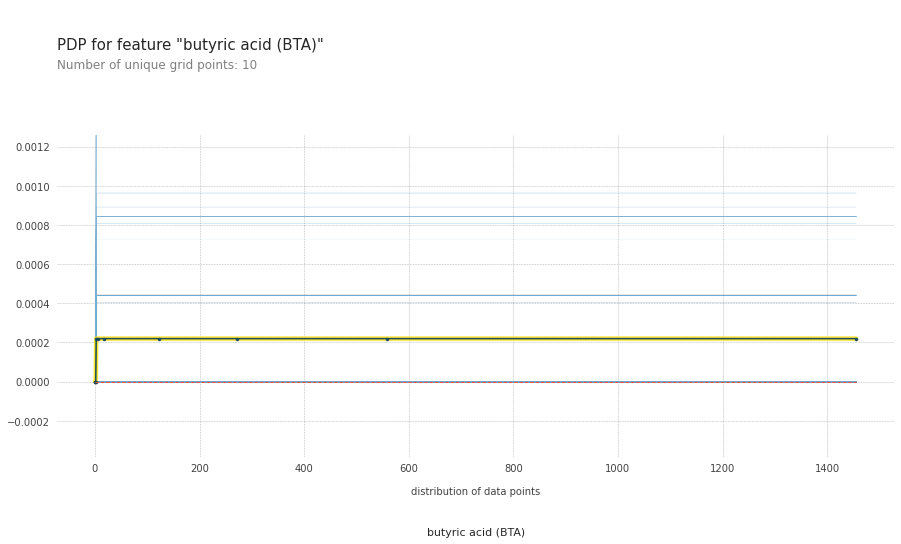

In [ ]:
pdp_bp = pdp.pdp_isolate(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    feature = 'Butricy aicd'
    )
fig, axes = pdp.pdp_plot(pdp_bp,
                         'butyric acid (BTA)',
                         plot_lines = True,
                         frac_to_plot=1,
                         plot_pts_dist = True)

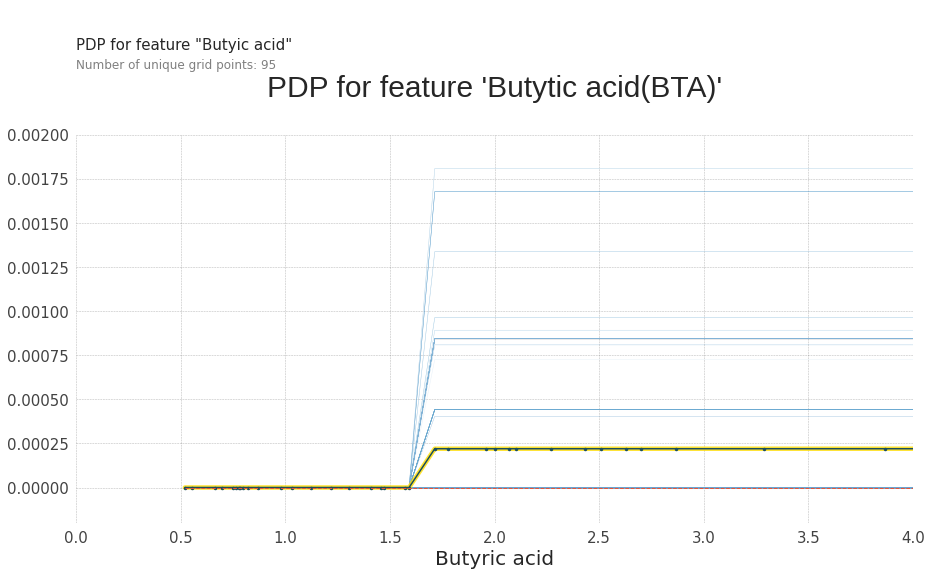

In [ ]:
pdp_plot(pdp_bp, 'Butyic acid', plot_lines = True)
plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

plt.rc('font', size = 100)
plt.rc('axes', labelsize=20)
plt.xlim((0, 4))
plt.ylim(-0.0002, 0.002)
plt.xlabel("Butyric acid", fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("PDP for feature 'Butytic acid(BTA)'\n", fontsize = 30);

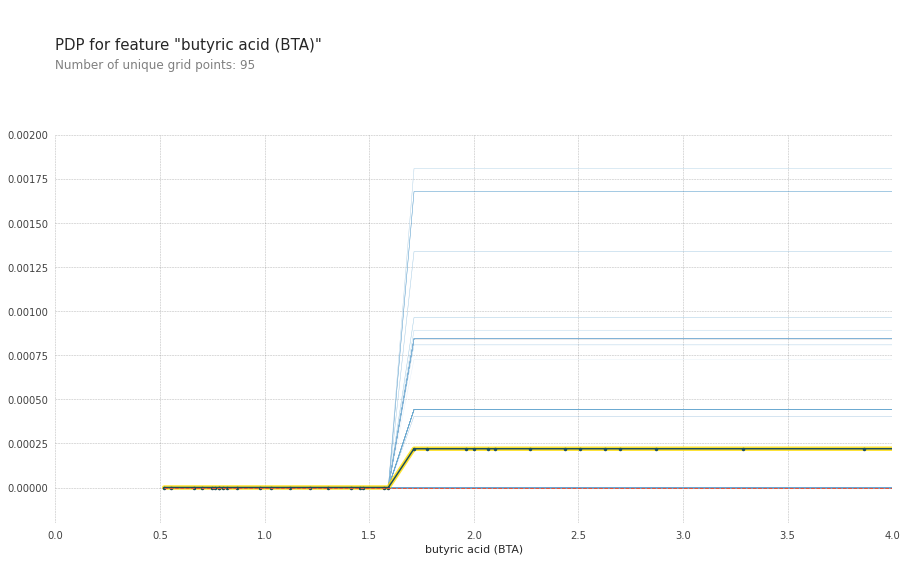

In [ ]:
pdp_plot(pdp_bp, 'butyric acid (BTA)', plot_lines = True)
plt.xlim((0, 4))
plt.ylim(-0.0002, 0.002)
plt.savefig("PDP isolate plot(svm_BTA).png")

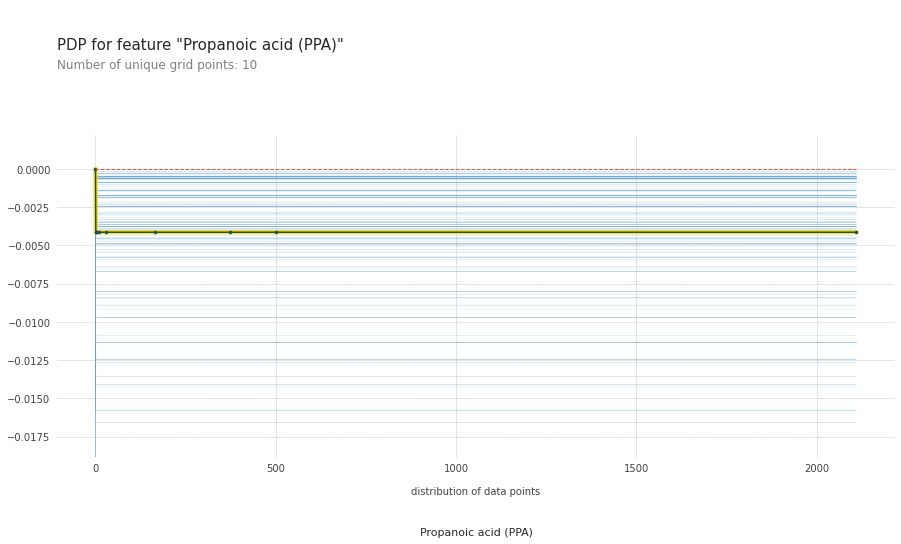

In [ ]:
pdp_bp = pdp.pdp_isolate(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    feature = 'Propionic acid'
    )
fig, axes = pdp.pdp_plot(pdp_bp,
                         'Propanoic acid (PPA)',
                         plot_lines = True,
                         frac_to_plot=1,
                         plot_pts_dist = True)

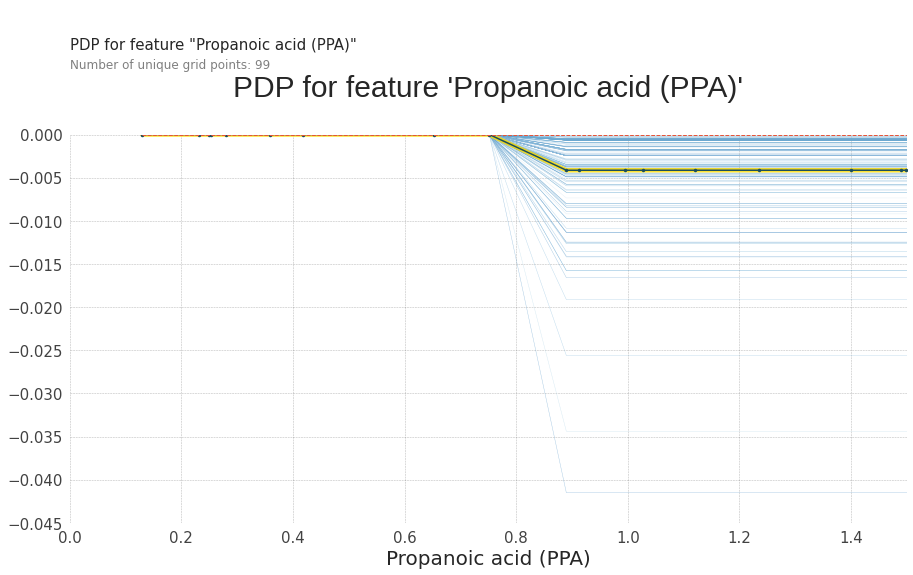

In [ ]:
pdp_plot(pdp_bp, 'Propanoic acid (PPA)', plot_lines = True)
plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

plt.rc('font', size = 100)
plt.rc('axes', labelsize=20)
plt.xlim((0, 1.5))
plt.ylim(-0.045, 0.0)
plt.xlabel("Propanoic acid (PPA)", fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("PDP for feature 'Propanoic acid (PPA)'\n", fontsize = 30);
#plt.savefig("PDP isolate plot(svm_PPA).png")

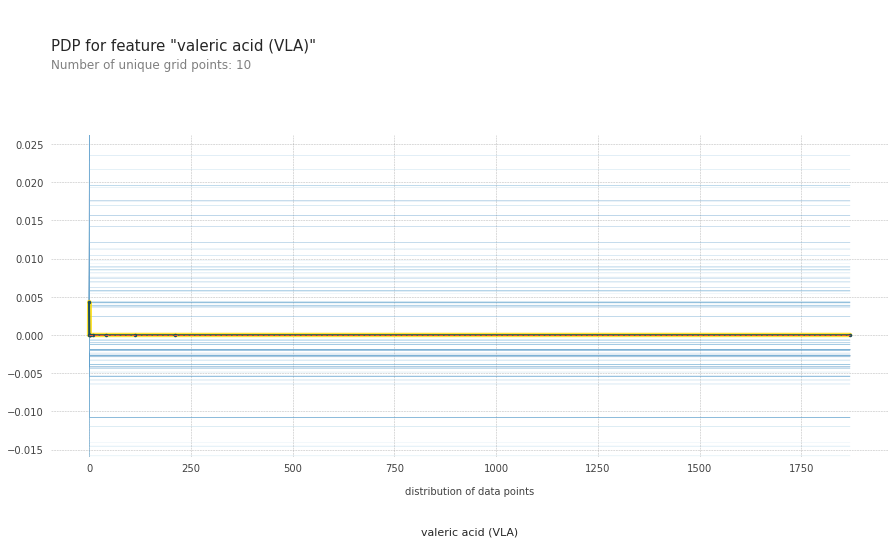

In [ ]:
pdp_bp = pdp.pdp_isolate(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    feature = 'Valeric acid'
    )
fig, axes = pdp.pdp_plot(pdp_bp,
                         'valeric acid (VLA)',
                         plot_lines = True,
                         frac_to_plot=1,
                         plot_pts_dist = True)

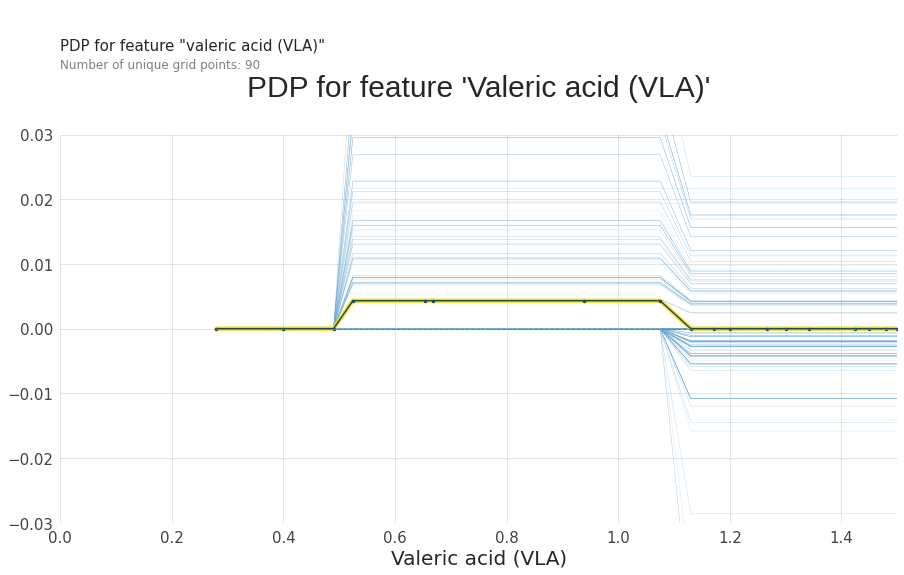

In [ ]:
pdp_plot(pdp_bp, 'valeric acid (VLA)', plot_lines = True)
plt.tick_params(axis = 'x', labelsize = 15)
plt.tick_params(axis = 'y', labelsize = 15)

plt.rc('font', size = 100)
plt.rc('axes', labelsize=20)
plt.xlim((0, 1.5))
plt.ylim(-0.03, 0.03)

plt.xlabel("Valeric acid (VLA)", fontsize = 20)
plt.yticks(fontsize = 15)
plt.title("PDP for feature 'Valeric acid (VLA)'\n", fontsize = 30);

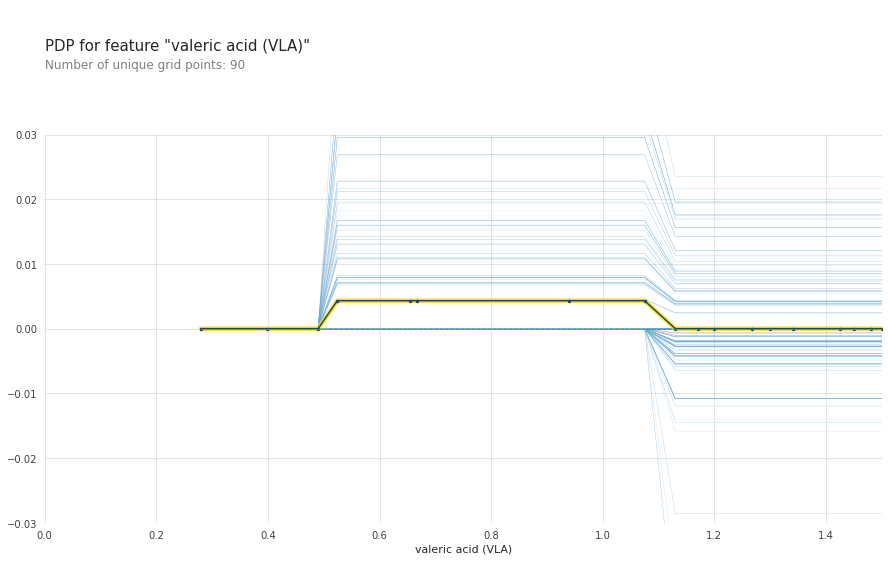

In [ ]:
pdp_plot(pdp_bp, 'valeric acid (VLA)', plot_lines = True)
plt.xlim((0, 1.5))
plt.ylim(-0.03, 0.03)
plt.savefig("PDP isolate plot(svm_VLA).png")

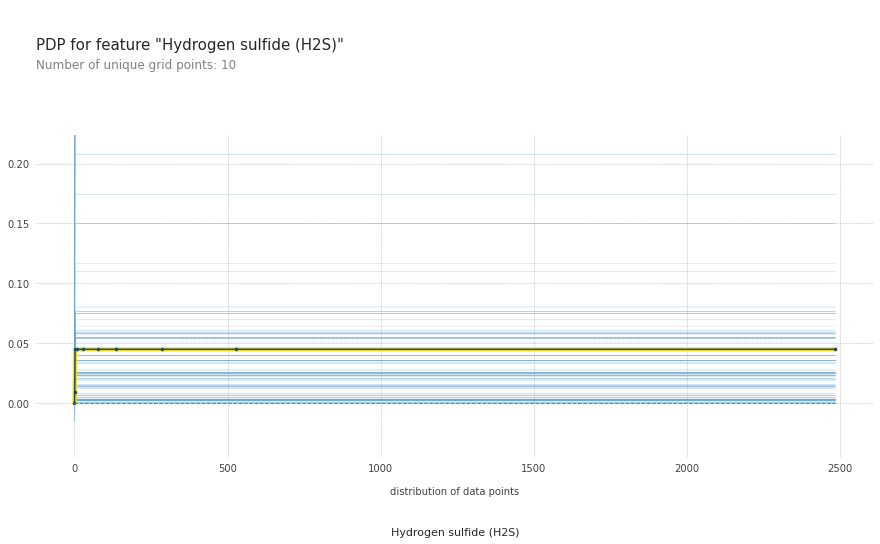

In [ ]:
pdp_bp = pdp.pdp_isolate(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    feature = 'Hydorgen sulfide'
    )
fig, axes = pdp.pdp_plot(pdp_bp,
                         'Hydrogen sulfide (H2S)',
                         plot_lines = True,
                         frac_to_plot=1,
                         plot_pts_dist = True)

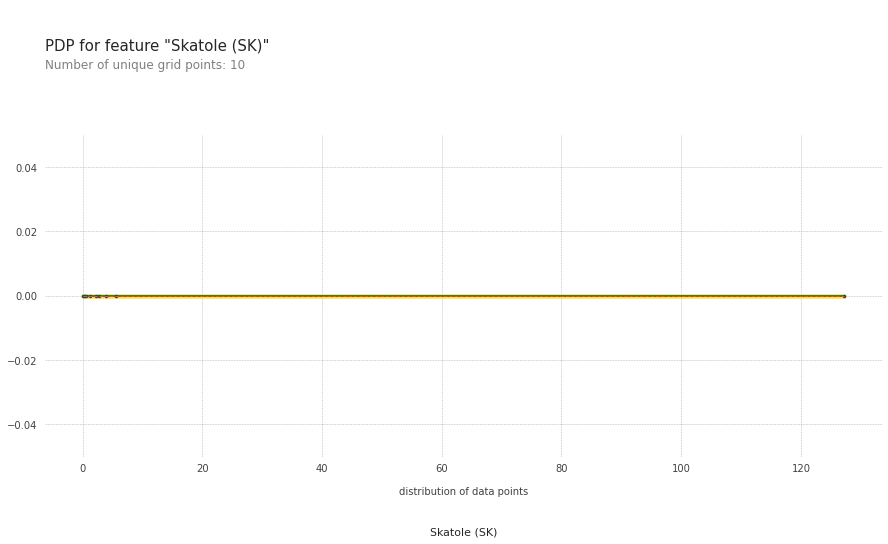

In [ ]:
pdp_bp = pdp.pdp_isolate(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    feature = 'Skatole'
    )
fig, axes = pdp.pdp_plot(pdp_bp,
                         'Skatole (SK)',
                         plot_lines = True,
                         frac_to_plot=1,
                         plot_pts_dist = True)

In [ ]:
isolate_option(odor_features, rf_model, tp = True)

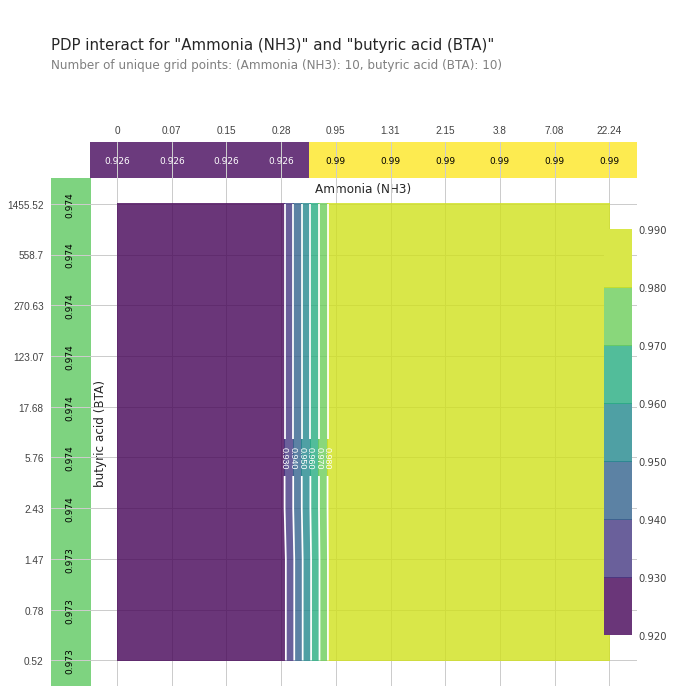

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Butricy aicd']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'butyric acid (BTA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

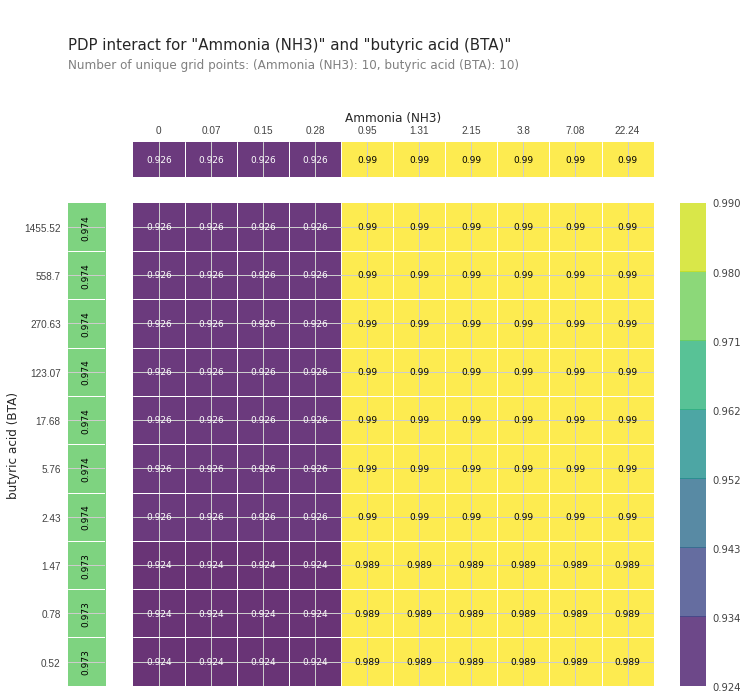

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Butricy aicd']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'butyric acid (BTA)'],
    plot_type = 'grid',
    x_quantile = True,
    plot_pdp = True
)

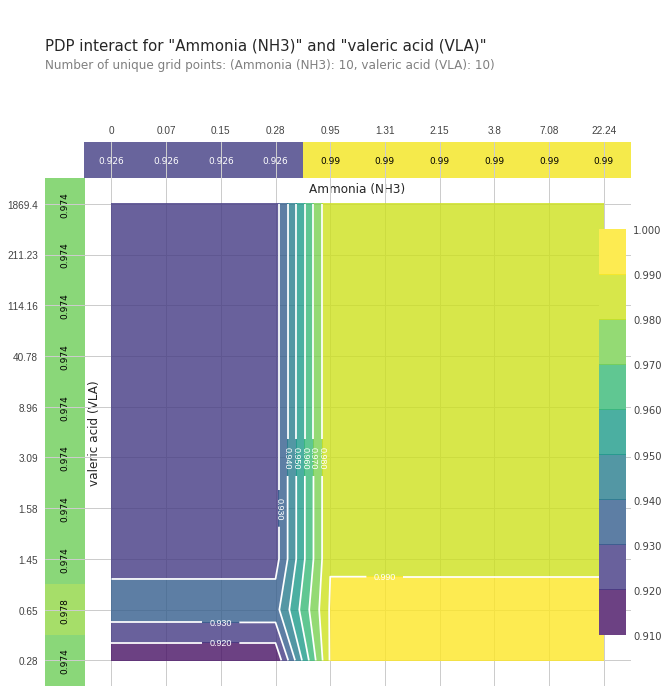

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Valeric acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'valeric acid (VLA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

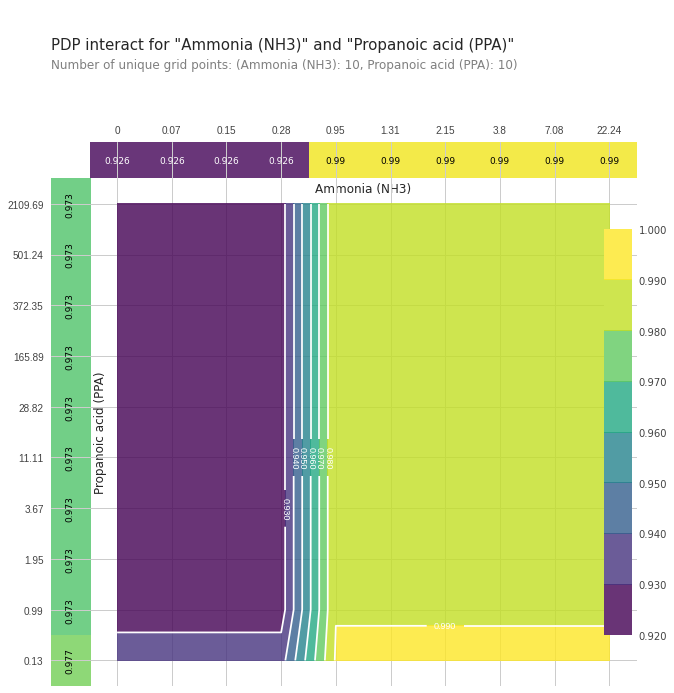

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Propionic acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'Propanoic acid (PPA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

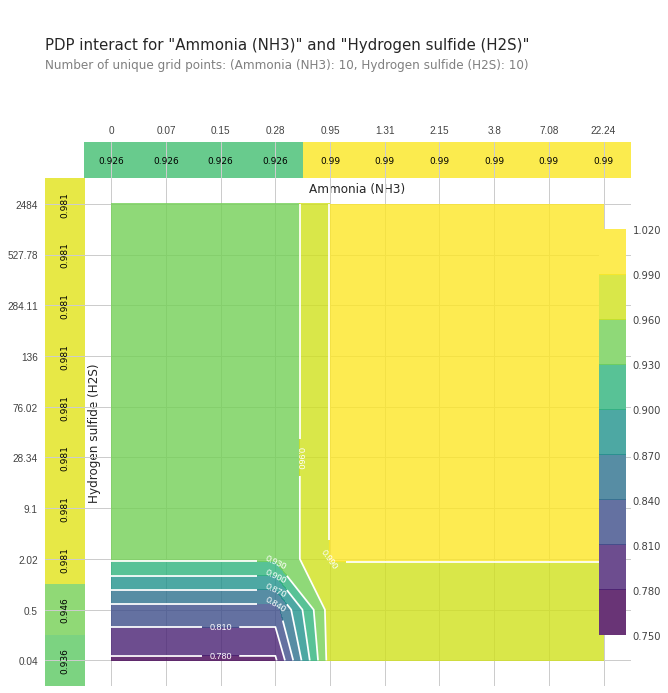

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'Hydrogen sulfide (H2S)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

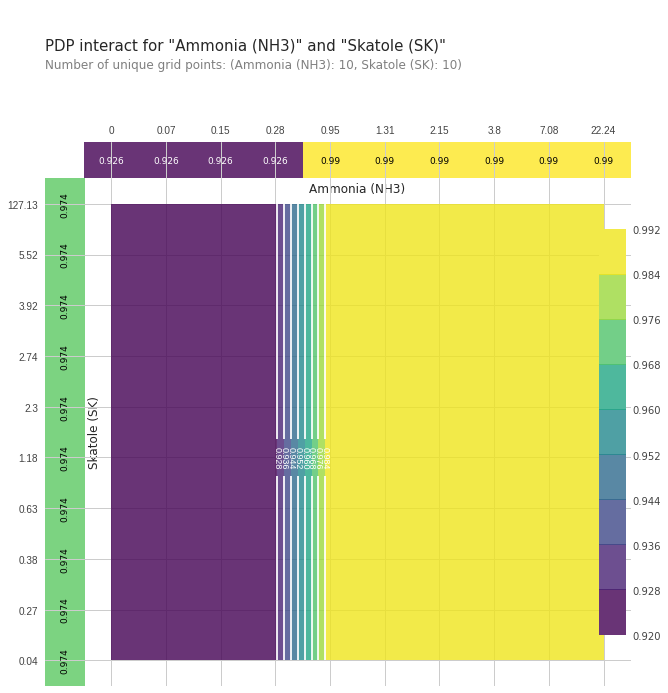

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

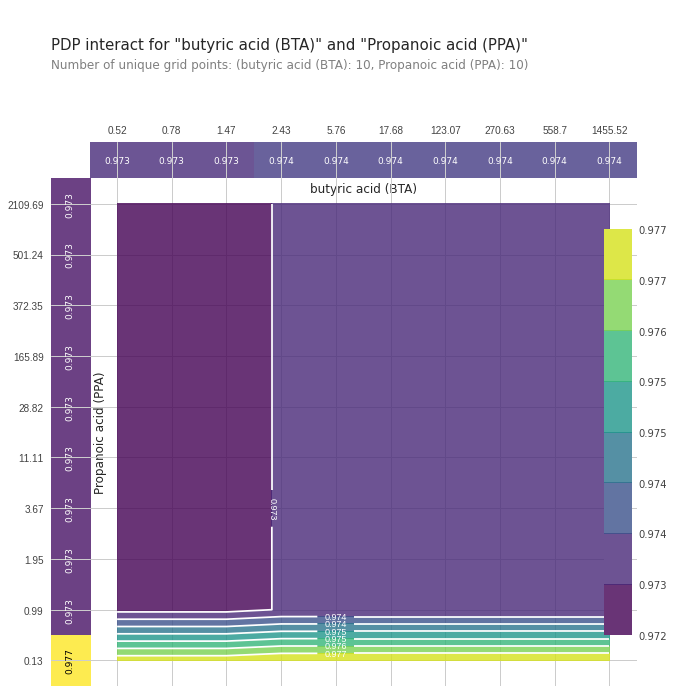

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Propionic acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)', 'Propanoic acid (PPA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

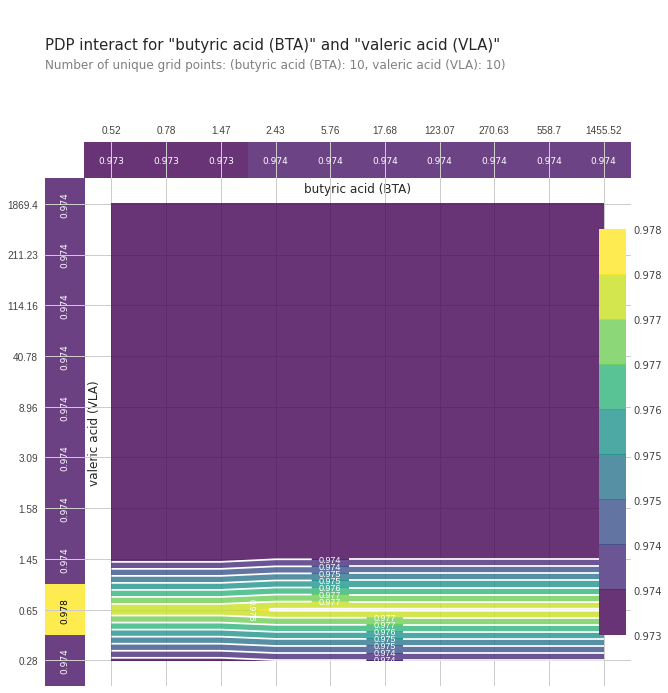

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Valeric acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)', 'valeric acid (VLA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

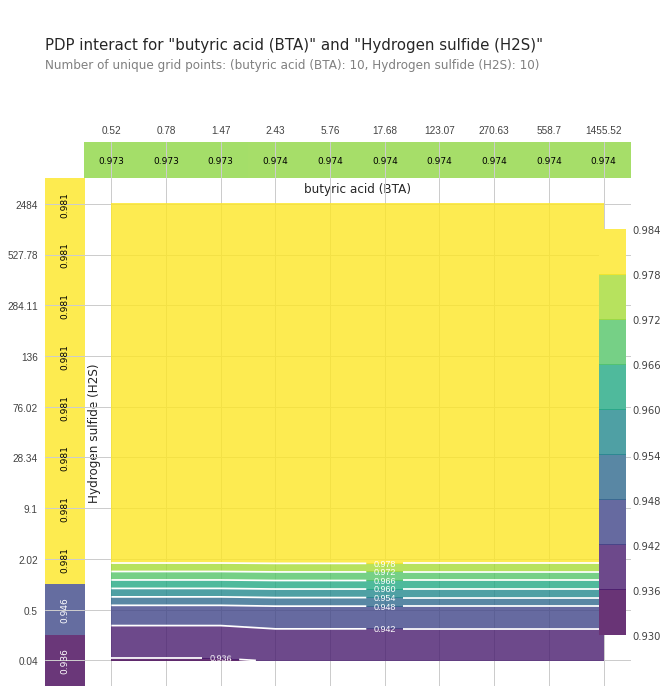

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)', 'Hydrogen sulfide (H2S)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

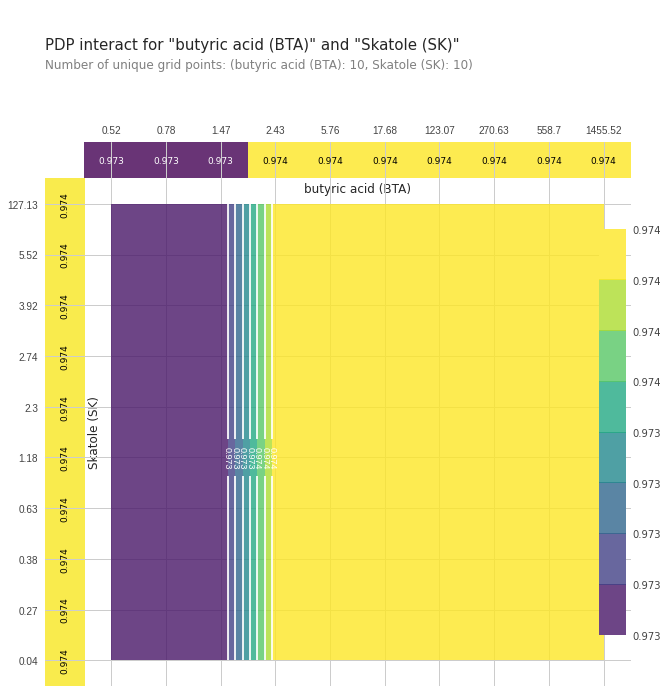

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

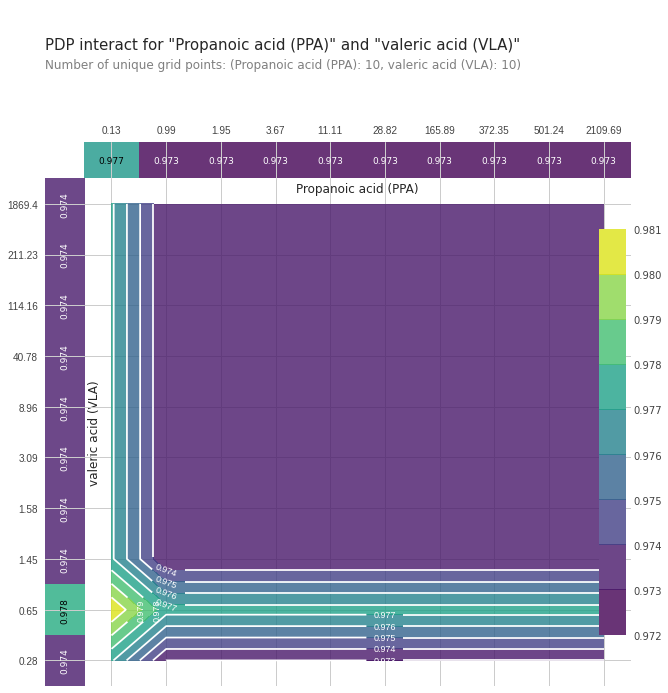

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Valeric acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propanoic acid (PPA)','valeric acid (VLA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

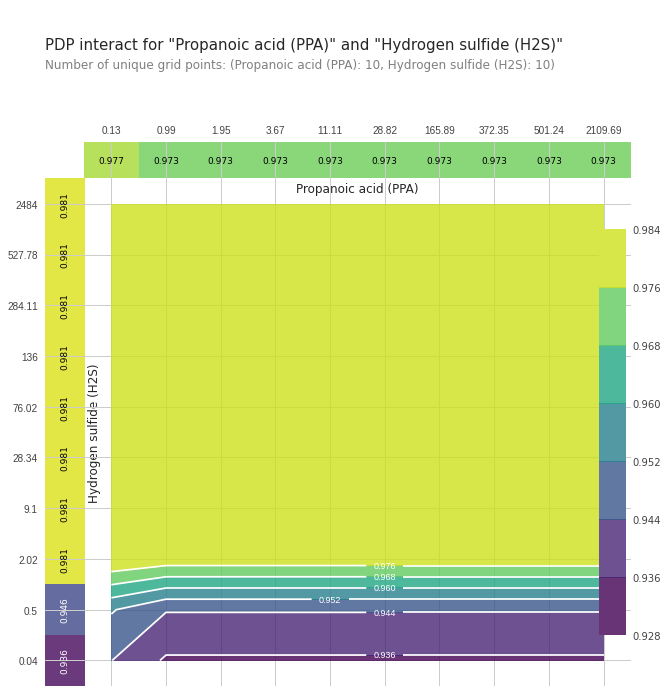

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propanoic acid (PPA)','Hydrogen sulfide (H2S)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

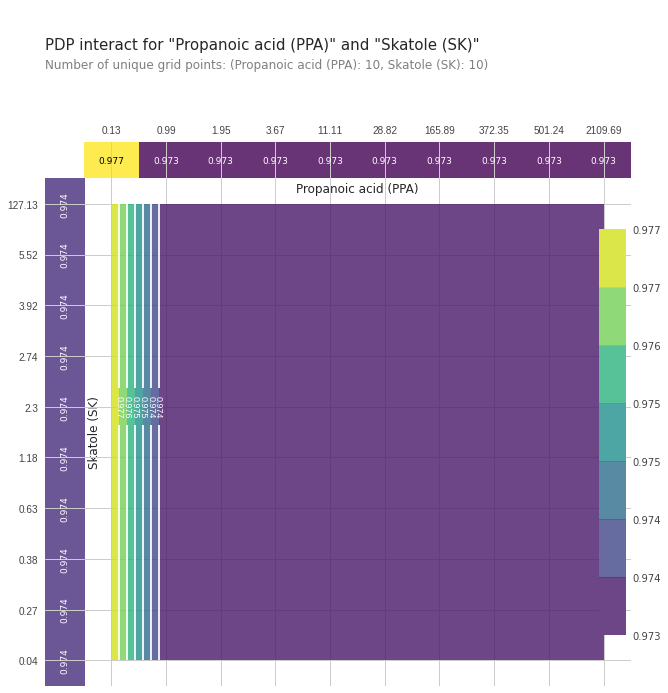

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propanoic acid (PPA)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

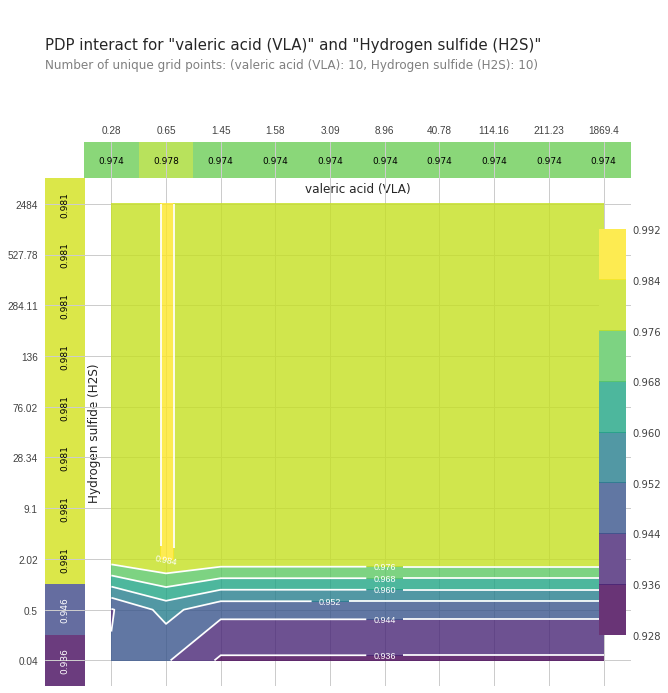

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Valeric acid', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['valeric acid (VLA)','Hydrogen sulfide (H2S)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

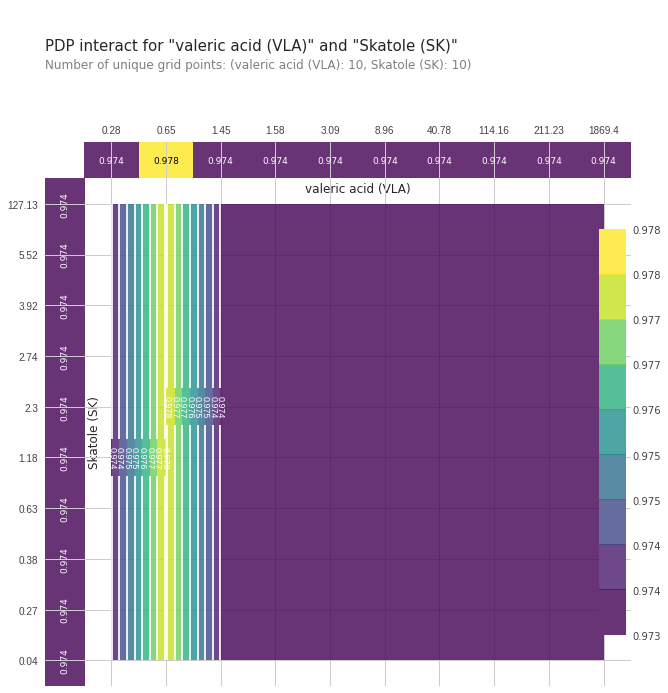

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Valeric acid', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['valeric acid (VLA)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

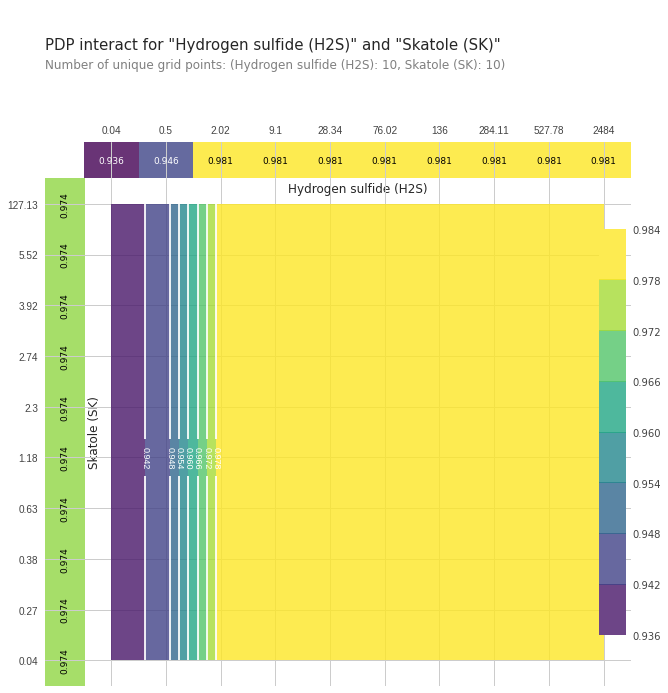

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = xg_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Hydorgen sulfide','Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Hydrogen sulfide (H2S)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
#plt.title("PDP Interaction plot(H2S, SK)")
plt.savefig("PDP Interaction plot(H2S, SK).png")

In [ ]:
def interaction_plot(features_, model, type_):
  odor_list = list(permutations(set(features_), 2))
  for i in tqdm(range(len(odor_list))):
    pdp_interaction = pdp.pdp_interact(
                                        model = model,
                                        dataset = dataset,
                                        model_features = features_,
                                        features = [odor_list[i][0], odor_list[i][1]]
                                      )
    fig, axes = pdp.pdp_interact_plot(
                                         pdp_interact_out = pdp_interaction,
                                         feature_names = [odor_list[i][0], odor_list[i][1]],
                                         plot_type = type_,
                                         x_quantile = True,
                                         plot_pdp = True
                                         )

In [ ]:
interaction_plot(odor_features, rf_model, 'grid')

In [ ]:
interaction_plot(odor_features, rf_model, 'contour')

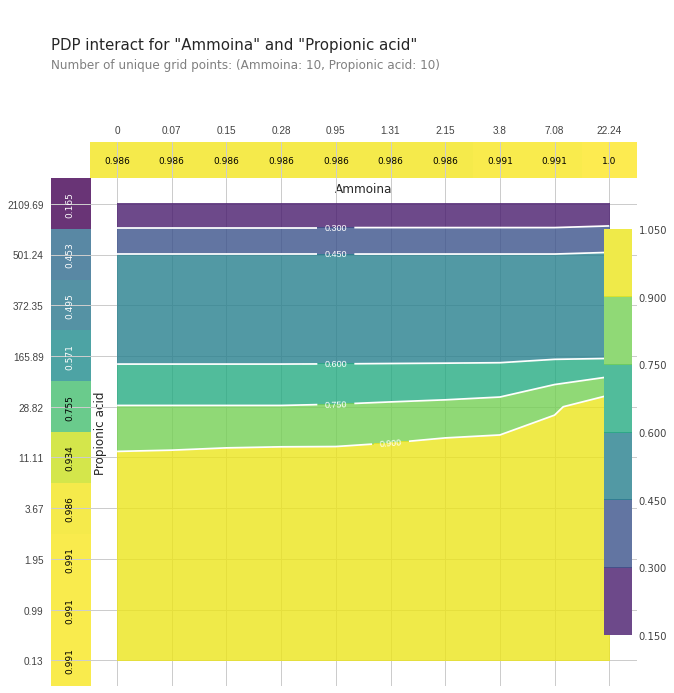

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Propionic acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammoina', 'Propionic acid'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

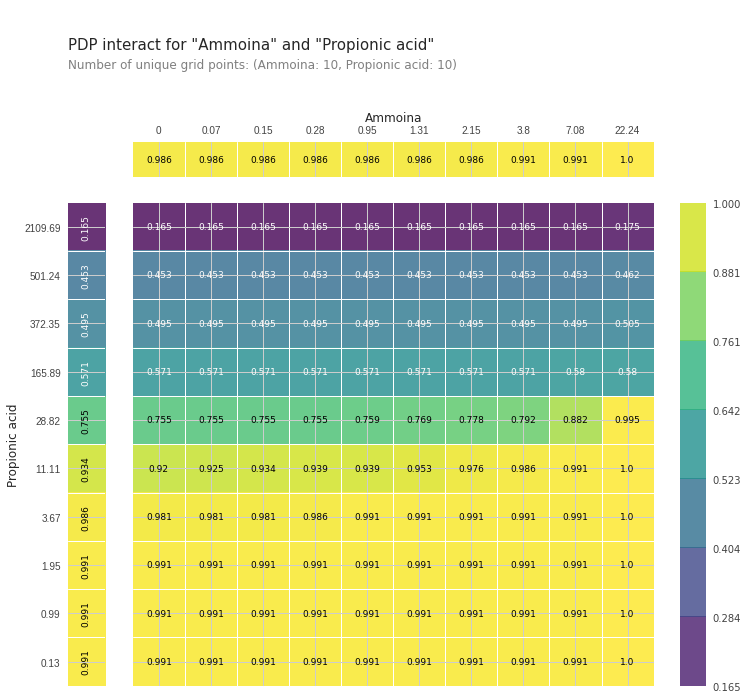

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Propionic acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammoina', 'Propionic acid'],
    plot_type = 'grid',
    x_quantile = True,
    plot_pdp = True
)

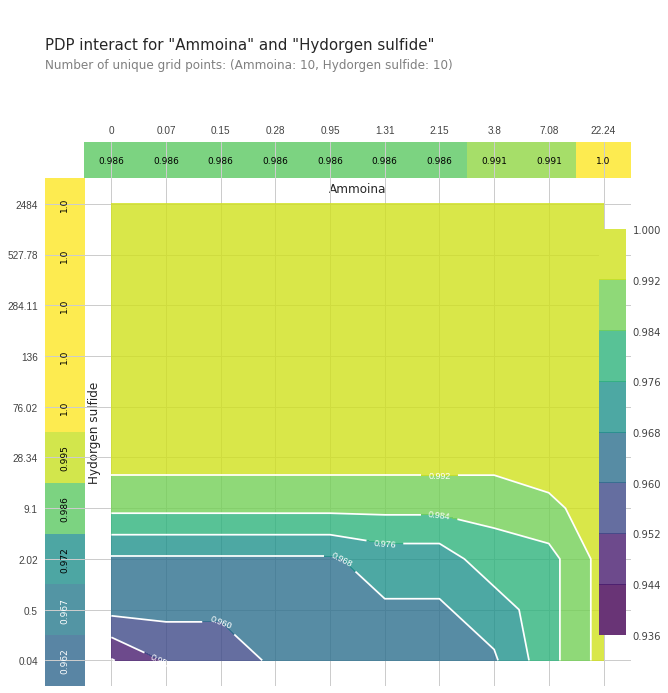

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammoina', 'Hydorgen sulfide'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

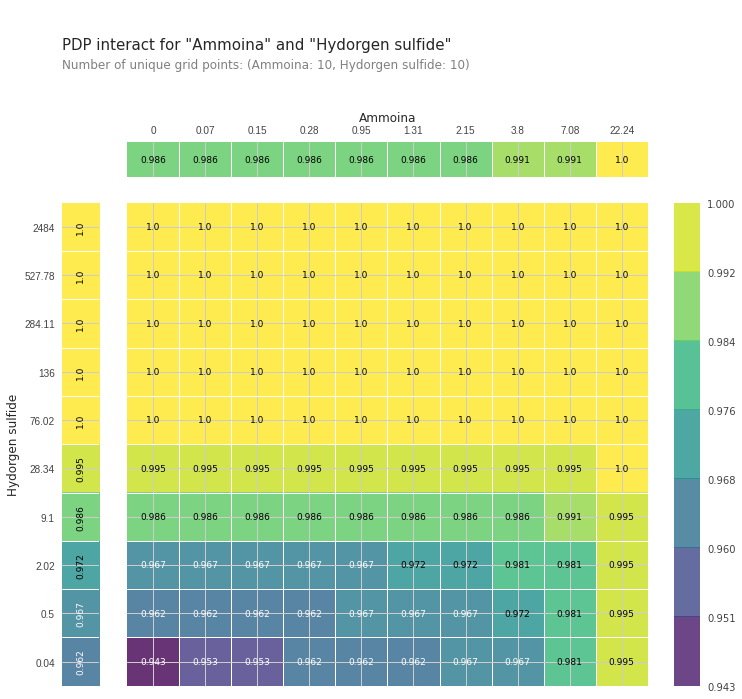

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammoina', 'Hydorgen sulfide'],
    plot_type = 'grid',
    x_quantile = True,
    plot_pdp = True
)

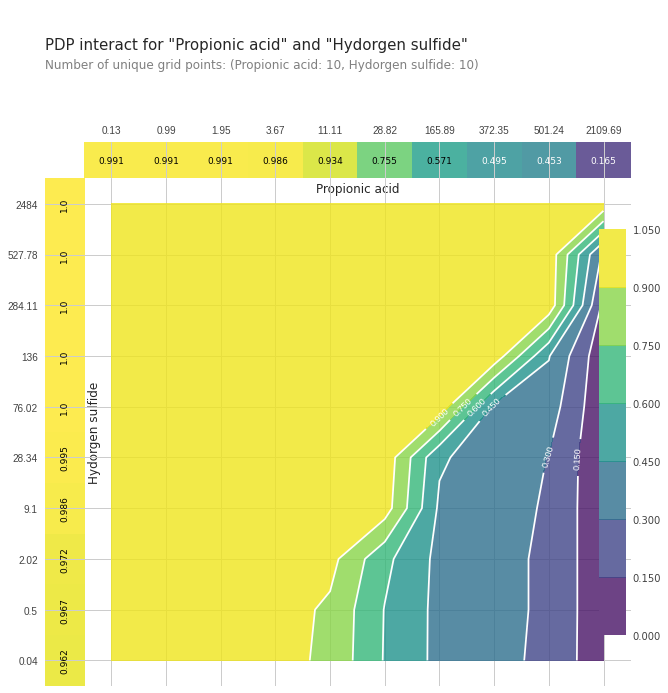

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propionic acid', 'Hydorgen sulfide'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

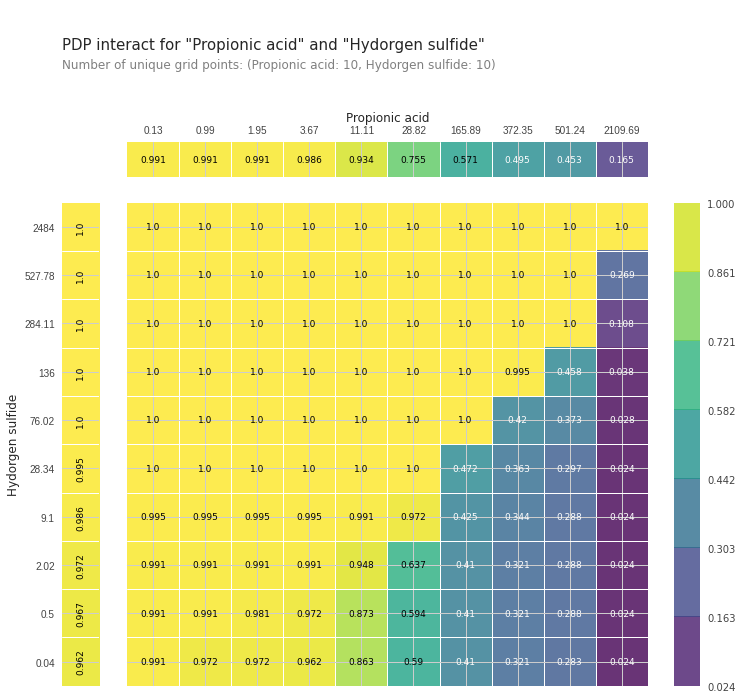

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propionic acid', 'Hydorgen sulfide'],
    plot_type = 'grid',
    x_quantile = True,
    plot_pdp = True
)

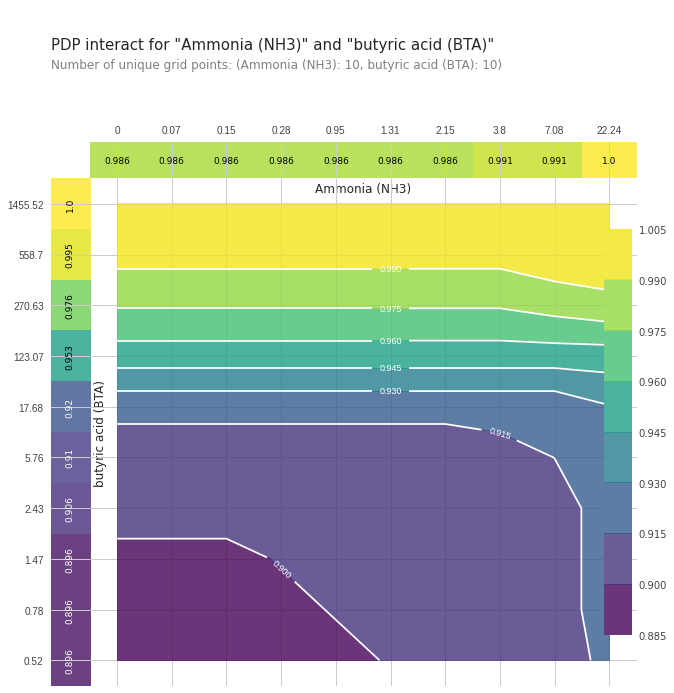

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Butricy aicd']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'butyric acid (BTA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
plt.savefig("PDP Interaction plot(NH3,BTA).png")

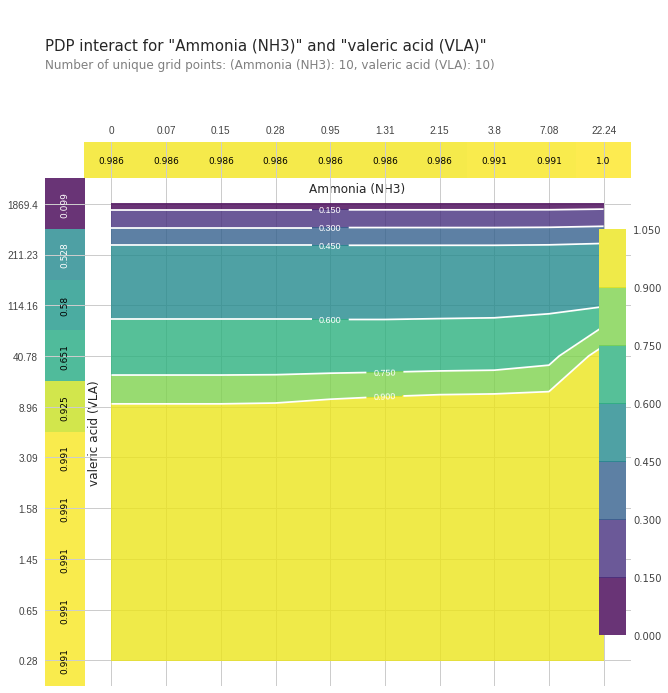

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Valeric acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'valeric acid (VLA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
plt.savefig("PDP Interaction plot(NH3,VLA).png")

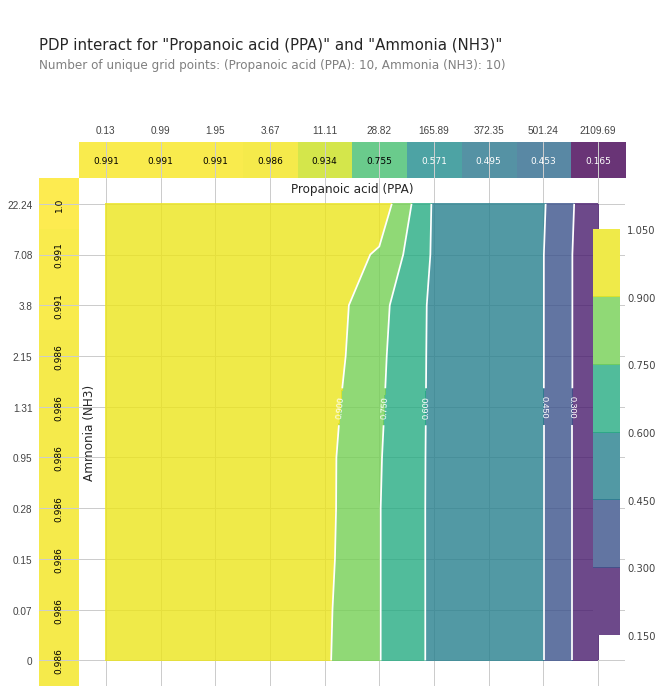

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Ammoina']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propanoic acid (PPA)', 'Ammonia (NH3)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
plt.savefig("PDP Interaction plot(PPA, NH3).png")

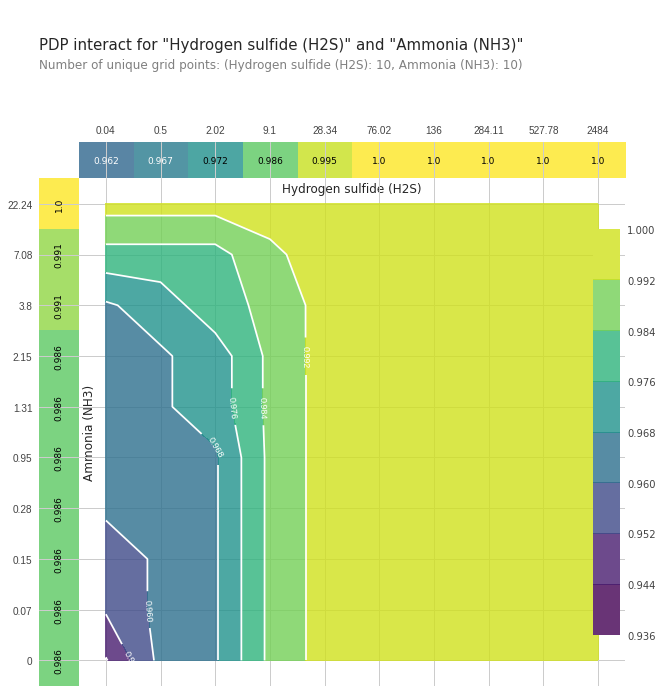

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Hydorgen sulfide', 'Ammoina']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Hydrogen sulfide (H2S)', 'Ammonia (NH3)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
plt.savefig("PDP Interaction plot(H2S, NH3).png")

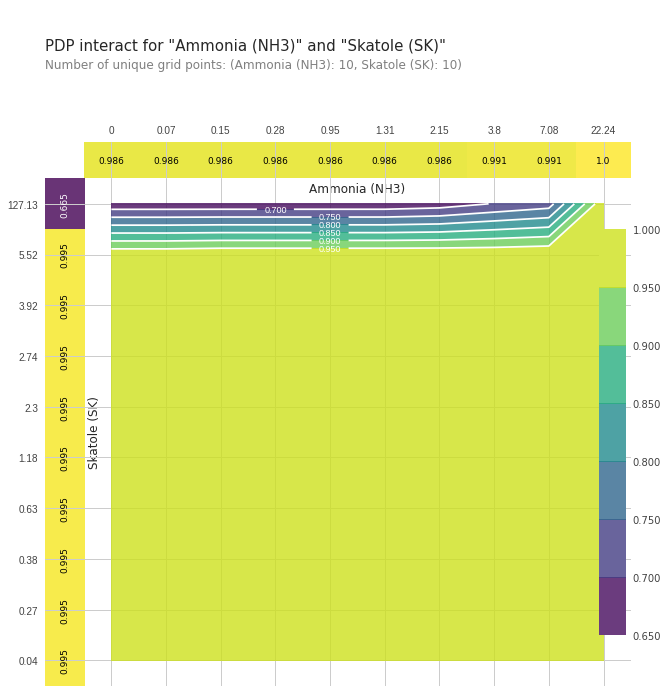

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Ammoina', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Ammonia (NH3)', 'Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

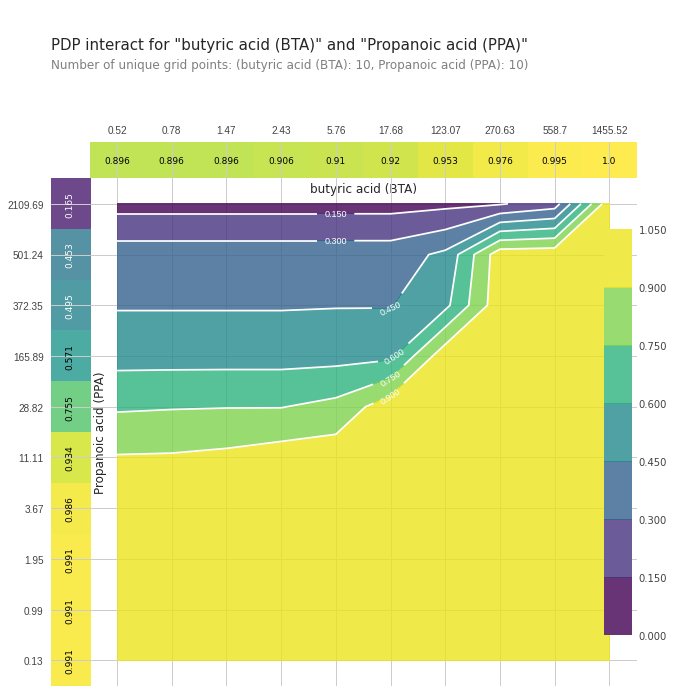

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Propionic acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)', 'Propanoic acid (PPA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
plt.savefig("PDP Interaction plot(BTA, PPA).png")

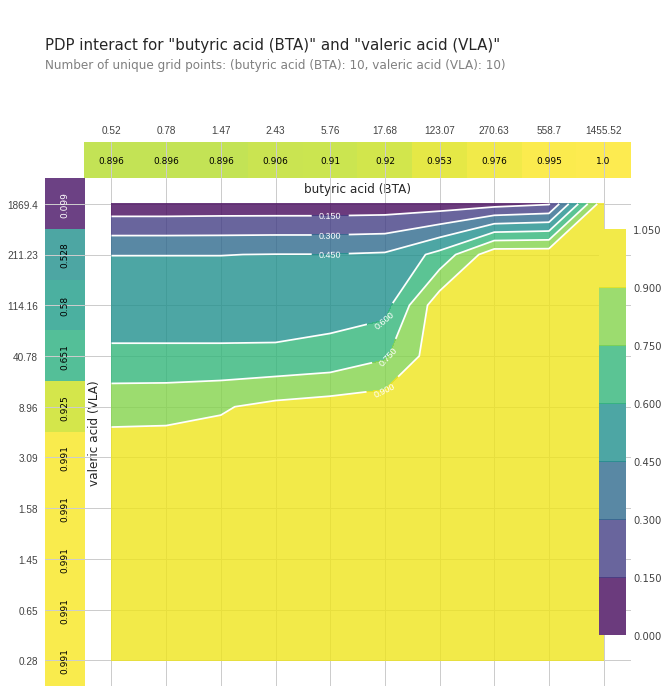

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Valeric acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)', 'valeric acid (VLA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
plt.savefig("PDP Interaction plot(BTA, VLA).png")

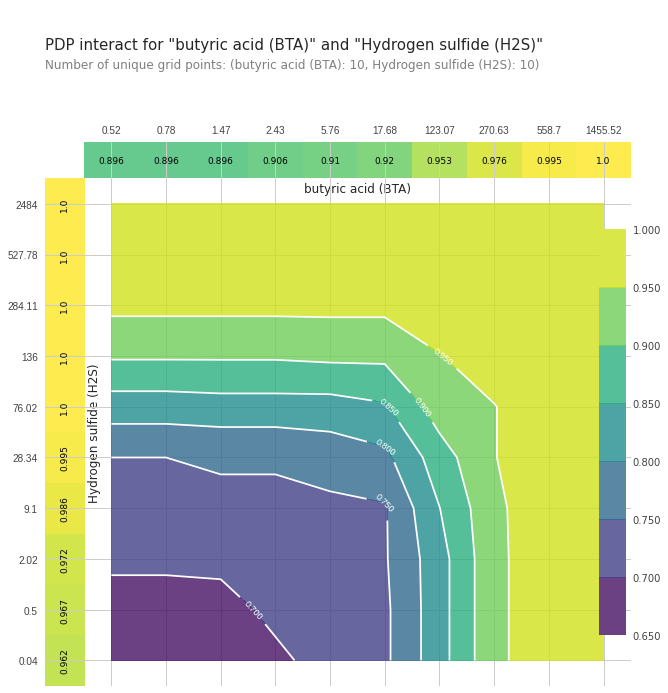

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)', 'Hydrogen sulfide (H2S)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

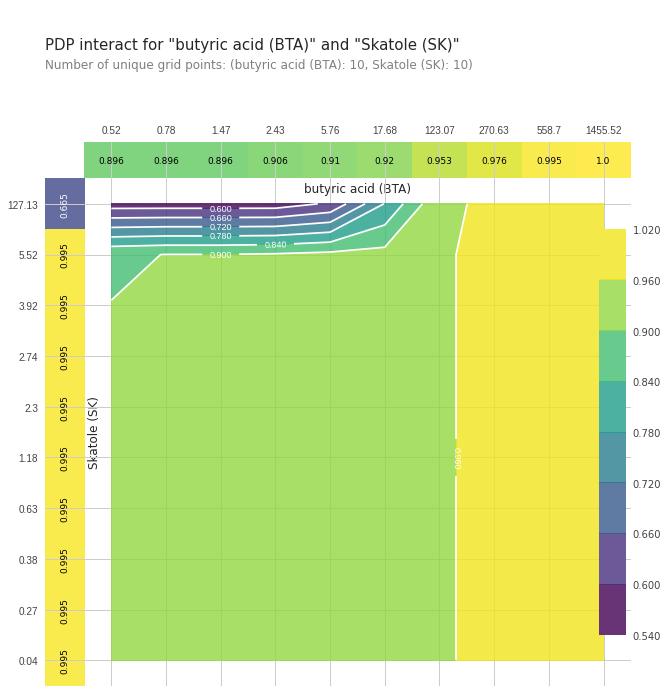

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Butricy aicd', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['butyric acid (BTA)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

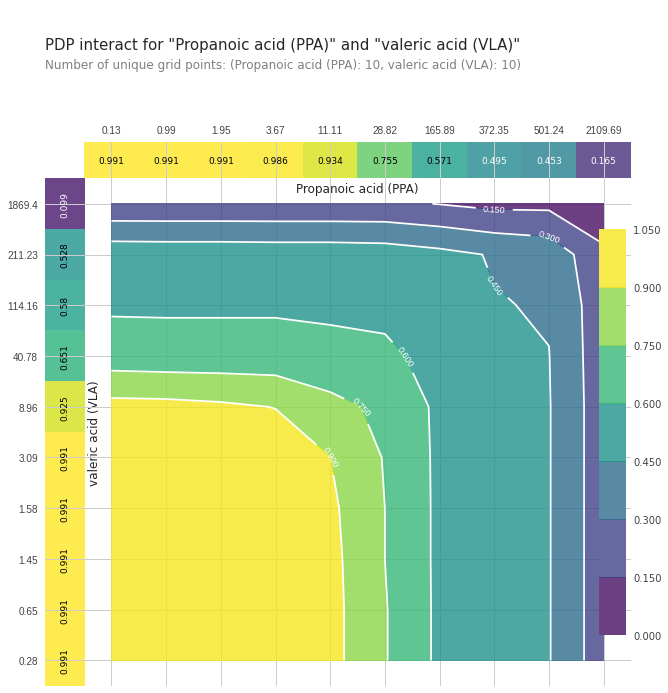

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Valeric acid']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propanoic acid (PPA)','valeric acid (VLA)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
plt.savefig("PDP Interaction plot(PPA, VLA).png")

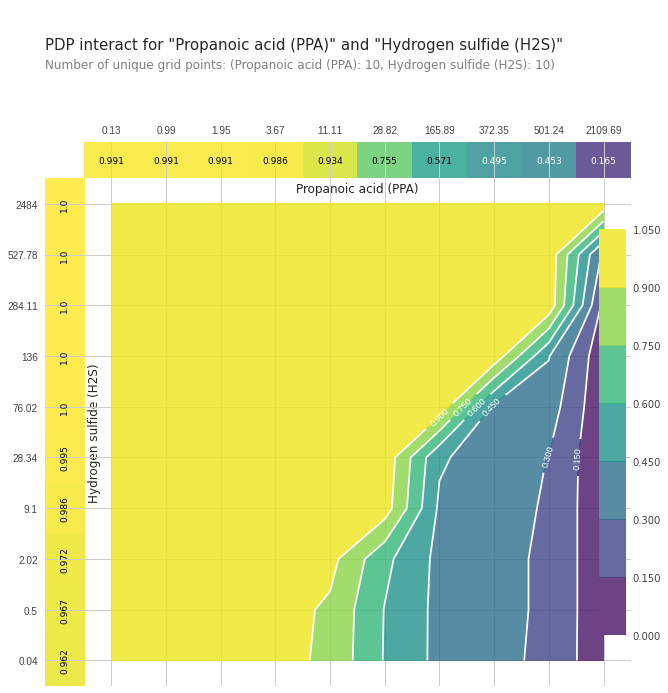

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propanoic acid (PPA)','Hydrogen sulfide (H2S)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

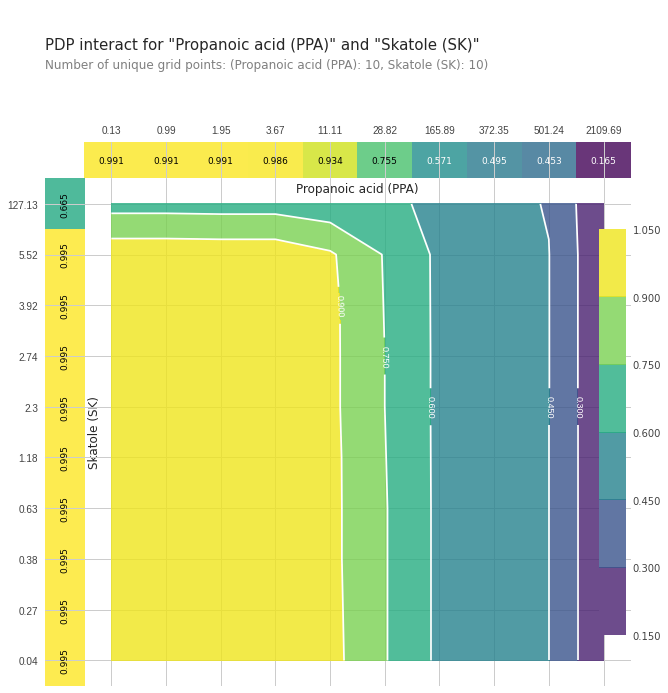

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Propionic acid', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Propanoic acid (PPA)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

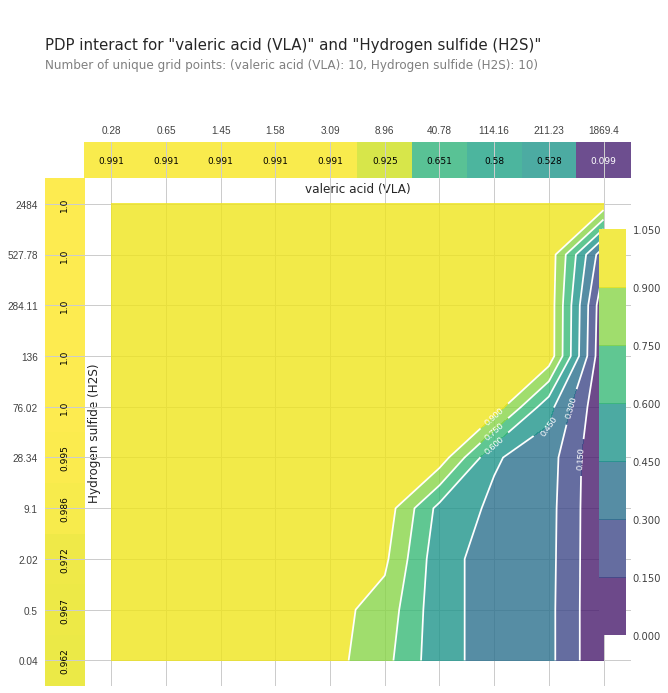

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Valeric acid', 'Hydorgen sulfide']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['valeric acid (VLA)','Hydrogen sulfide (H2S)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

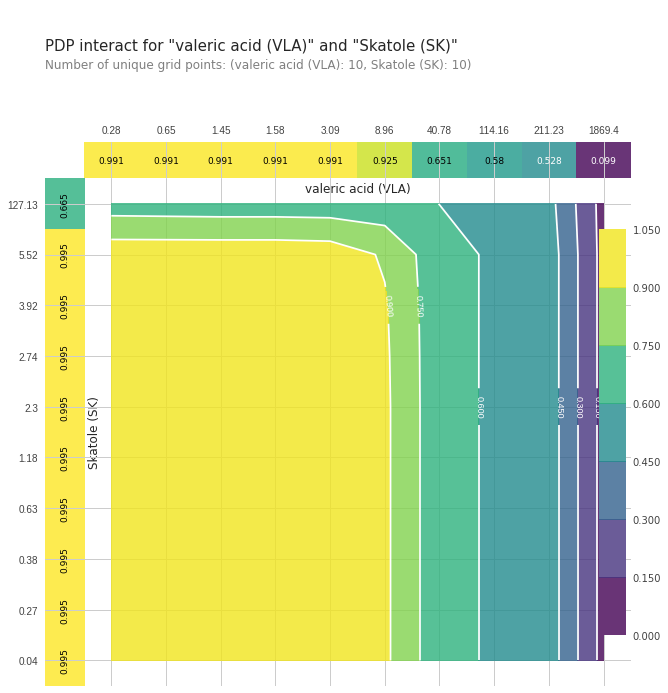

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Valeric acid', 'Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['valeric acid (VLA)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)

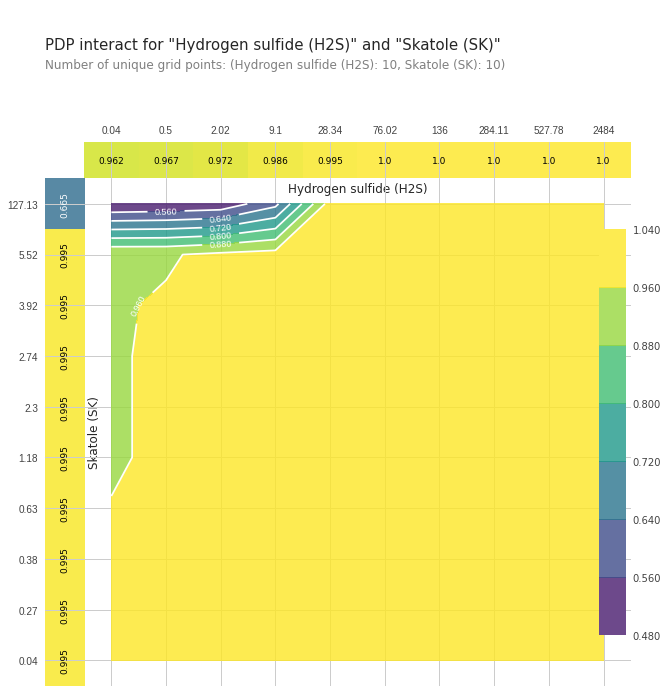

In [ ]:
pdp_interaction = pdp.pdp_interact(
    model = sv_model,
    dataset = dataset,
    model_features = odor_features,
    features = ['Hydorgen sulfide','Skatole']
)
fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out = pdp_interaction,
    feature_names = ['Hydrogen sulfide (H2S)','Skatole (SK)'],
    plot_type = 'contour',
    x_quantile = True,
    plot_pdp = True
)
#plt.title("PDP Interaction plot(H2S, SK)")
plt.savefig("PDP Interaction plot(H2S, SK).png")